In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sodapy import Socrata

import requests
import re
from bs4 import BeautifulSoup
import sqlite3
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
import difflib

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, ColumnDataSource
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import PRGn, RdYlGn, BuGn, YlOrBr
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row, column
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter

In [2]:
%matplotlib inline

# Get mta turnstile data for preprocessing in SQL 

http://web.mta.info/developers/turnstile.html

In [ ]:
def get_hrefs(datepat):
    '''
    Get a list of the hrefs available from mta turnstile data website
    Parameters
    ----------
    datepat : str
        string representing regex pattern for a date (e.g., '21.*')

    Returns
    -------
    list of hrefs
    '''
    # main page containing all the mta turnstile links
    url = 'http://web.mta.info/developers/'
    response = requests.get(url + 'turnstile.html')
    soup = BeautifulSoup(response.content, features="lxml")

    # links to weeks of turnstile data
    href_pat = re.compile(r'.*data.*turnstile_' + datepat)
    hrefs = soup.find_all('a', attrs={'href': href_pat})
    hrefs = [url + h.attrs['href'] for h in hrefs]

    # remove dates prior to 2015 (the MTA schema changed then)
    hrefs = [href for href in hrefs if href_to_week(href) > '2014-12-31']

    return hrefs

In [ ]:
def href_to_week(href):
    week = href[href.find('turnstile_') + 10:href.find('.txt')]
    week = pd.to_datetime(week, yearfirst=True).strftime('%Y-%m-%d')
    return week

def load_week(href, con):
    '''
    Load one week of data into SQLite.
    '''
    week = href_to_week(href)

    print(f"Week: {week} -- Getting data ...")
    df = pd.read_csv(href)

    # strip whitespace from headers
    df.columns = df.columns.str.strip()

    # drop data into database
    print(f"Week: {week} -- Inserting into SQLite ...")
    df.to_sql("mta_data", con, if_exists='append', index=False)

In [ ]:
if __name__ == '__main__':
    # weeks to scrape
    datepat = "(220101|21)"
    hrefs = get_hrefs(datepat)

    # check for user confirmation
    weeks = [href_to_week(h) for h in hrefs]
    print(f"\n{len(weeks)} weeks to collect:\n")
    print(weeks)

    if input(f"\nContinue? (Y/n) ").lower() not in ['yes', 'y']:
        exit()

    # connect to (or create) mta_data SQLite database
    print("\nConnecting to (or creating) mta_data SQLite database ...\n")
    con = sqlite3.connect("mta_data.db")

    for href in hrefs:
        load_week(href, con)

    con.close()

    print("\nAll done!\n")

# Get mta fare data for preprocessing in SQL

http://web.mta.info/developers/fare.html

In [ ]:
def get_hrefs(datepat):
    '''
    Get a list of the hrefs available from mta turnstile data website
    Parameters
    ----------
    datepat : str
        string representing regex pattern for a date (e.g., '2101.*')

    Returns
    -------
    list of hrefs
    '''
    # main page containing all the mta turnstile links
    url = 'http://web.mta.info/developers/'
    response = requests.get(url + 'fare.html')
    soup = BeautifulSoup(response.content, features="lxml")

    # links to weeks of turnstile data
    href_pat = re.compile(r'.*data.*fares_' + datepat)
    hrefs = soup.find_all('a', attrs={'href': href_pat})
    hrefs = [url + h.attrs['href'] for h in hrefs]

    # remove dates prior to 2015 (the MTA schema changed then)
    hrefs = [href for href in hrefs if href_to_week(href) > '2014-12-31']

    return hrefs

In [ ]:
def href_to_week(href):
    week = href[href.find('fares_') + 6:href.find('.csv')]
    week = pd.to_datetime(week, yearfirst=True).strftime('%Y-%m-%d')
    return week

In [ ]:
# for mta-fares data after 2019/04/06 (not inclusive) due to changed column structure

def load_week_new(href, con):
    '''
    Load one week of data into SQLite.
    '''
    week = href_to_week(href)

    print(f"Week: {week} -- Getting data ...")
    df = pd.read_csv(href, skiprows=2)

    # strip whitespace from headers
    df.columns = df.columns.str.strip()
    
    # drop empty column
    df.drop("", axis=1, inplace=True)

    # 
    df['1-D UNL'] = 0
    df['14-D RFM UNL'] = 0
    df['14-D UNL'] = 0
    
    # create timestamp & date column
    df['timestamp'] = href[-8:-6] + "/" + href[-6:-4] + "/" + href[-10:-8]
    df['date'] = pd.to_datetime(df['timestamp'])
    
    # drop data into database
    print(f"Week: {week} -- Inserting into SQLite ...")
    df.to_sql("mta_fares", con, if_exists='append', index=False)

In [ ]:
# for mta-fares data before 2019/04/06 (inclusive) due to changed column structure

def load_week_old(href, con):
    '''
    Load one week of data into SQLite.
    '''
    week = href_to_week(href)

    print(f"Week: {week} -- Getting data ...")
    df = pd.read_csv(href, skiprows=2)

    # strip whitespace from headers
    df.columns = df.columns.str.strip()
    
    # drop empty column
    df.drop("", axis=1, inplace=True)

    # 
    df['FF VALUE'] = 0
    df['FF 7-DAY'] = 0
    df['FF 30-DAY'] = 0
    
    # create timestamp & date column
    df['timestamp'] = href[-8:-6] + "/" + href[-6:-4] + "/" + href[-10:-8]
    df['date'] = pd.to_datetime(df['timestamp'])
    
    # drop data into database
    print(f"Week: {week} -- Inserting into SQLite ...")
    df.to_sql("mta_fares", con, if_exists='append', index=False)

In [ ]:
# Get mta fares data

if __name__ == '__main__':
    # regex for weeks to scrape
    datepat = "(220108|220101|21|20)"
    hrefs = get_hrefs(datepat)

    # check for user confirmation
    weeks = [href_to_week(h) for h in hrefs]
    print(f"\n{len(weeks)} weeks to collect:\n")
    print(weeks)

    if input(f"\nContinue? (Y/n) ").lower() not in ['yes', 'y']:
        exit()

    # connect to (or create) mta_data SQLite database
    print("\nConnecting to (or creating) mta_data SQLite database ...\n")
    con = sqlite3.connect("mta_data.db")

    for href in hrefs:
        load_week_new(href, con)

    con.close()

    print("\nAll done!\n")

In [4]:
engine = create_engine("sqlite:////media/fabian/VM_space/Metis/01_EDA/01_Project/mta_data.db")
engine

Engine(sqlite:////media/fabian/VM_space/Metis/01_EDA/01_Project/mta_data.db)

In [5]:
all_tables = engine.table_names()
all_tables

['mta_data', 'mta_data_fares', 'mta_fares']

# Preprocessing of mta turnstile & fare data and merge to main data table 

In [ ]:
engine.execute('ALTER TABLE mta_fares ADD COLUMN date_from DATETIME')
engine.execute('ALTER TABLE mta_fares ADD COLUMN date_to DATETIME')
engine.execute('UPDATE mta_fares SET date_from = datetime(date, "-14 days")')
engine.execute('UPDATE mta_fares SET date_to = datetime(date, "-7 days")')

In [ ]:
column_fare_names = {'FF': 'full_fare','STATION': 'station','REMOTE': 'unit','SEN/DIS': 'senior_disabled', '7-D AFAS UNL': 'ada_farecard_7d', '30-D AFAS/RMF UNL': 'ada_media_30d',
                     'JOINT RR TKT': 'joint_railroad_ticket', '7-D UNL': 'unlimited_7d', '30-D UNL': 'unlimited_30d',
                     '7D-XBUS PASS': 'expressbus_7d', 'TCMC': 'transit_check', 'RF 2 TRIP': 'reduced_2trips',
                     'RR UNL NO TRADE': 'railroad_unlimited', 'TCMC ANNUAL MC': 'transit_check_yearly', 
                     'MR EZPAY EXP': 'mail_and_ride_express', 'MR EZPAY UNL': 'mail_and_ride_unlimited', 
                     'PATH 2-T': 'path_2trips', 'AIRTRAIN FF': 'airtrain_full_fare', 'AIRTRAIN 30-D': 'airtrain_30d',
                     'AIRTRAIN 10-T': 'airtrain_10trips', 'AIRTRAIN MTHLY': 'airtrain_monthly', 'STUDENTS': 'students',
                     'NICE 2-T': 'nice_2trips', 'CUNY-120': 'university_120trips', 'CUNY-60': 'university_60trips',
                     'FF VALUE': 'full_fare_value', 'FF 7-DAY': 'full_fare_7d', 'FF 30-DAY': 'full_fare_30d', 
                    '1-D UNL': 'unlimited_1d', '14-D UNL': 'unlimited_14d', '14-D RFM UNL': 'reduced_14d'}

In [ ]:
# Function to rename columns to get readable names of metrocard-groups based on a dictionary

def rename_sql_columns(table, dict_names):
    for i in range(len(list(dict_names.values()))):
        s1 = 'ALTER TABLE '
        s2 = table
        s3 = ' RENAME COLUMN '
        
        element1 = list(dict_names.keys())[i]
        s4 = str(element1)
        
        s5 = ' TO '
        element2 = list(dict_names.values())[i]
        s6 = str(element2)
        
        s_final = s1+s2+s3+'"'+s4+'"'+s5+s6
        engine.execute(s_final)
    return('Done. Columns renamed in DB.')

In [ ]:
rename_sql_columns('mta_fares', column_fare_names)

In [ ]:
engine.execute('ALTER TABLE mta_fares ADD COLUMN sum_metrocard_swipes INT')

In [ ]:
engine.execute('UPDATE mta_fares SET sum_metrocard_swipes = (full_fare+senior_disabled+ada_farecard_7d+ada_media_30d+joint_railroad_ticket+unlimited_7d+unlimited_30d+expressbus_7d+transit_check+reduced_2trips+railroad_unlimited+transit_check_yearly+mail_and_ride_express+mail_and_ride_unlimited+path_2trips+airtrain_full_fare+airtrain_30d+airtrain_10trips+airtrain_monthly+students+nice_2trips+university_120trips+university_60trips+full_fare_value+full_fare_7d+full_fare_30d+unlimited_1d+unlimited_14d+reduced_14d)')

In [ ]:
pct_names = {'high_school_students': 'students', 'cuny_students': ['university_120trips', 'university_60trips'], 
            'full_fares': ['full_fare', 'full_fare_value', 'full_fare_7d', 'full_fare_30d'],
            'unlimited': ['unlimited_7d', 'unlimited_30d', 'unlimited_1d', 'unlimited_14d'], 'railroad': ['railroad_unlimited', 'joint_railroad_ticket'],
             'mail_and_ride': ['mail_and_ride_express', 'mail_and_ride_unlimited'], 
            'airtrain': ['airtrain_full_fare', 'airtrain_30d', 'airtrain_10trips', 'airtrain_monthly'],
            'seniors_disabled': 'senior_disabled', 'other_check': ['ada_farecard_7d', 'ada_media_30d', 'expressbus_7d', 'transit_check', 'reduced_2trips', 'transit_check_yearly', 'path_2trips', 'nice_2trips', 'reduced_14d']}

In [ ]:
# Function to sum similar metrocard-groups and calculate %-share of total for metrocard groups

def create_column_percentages(columns_dict, column_total, table):
    for i in range(len(columns_dict.keys())):
        s_add_column_1 = 'ALTER TABLE '
        s_add_column_2 = table
        s_add_column_3 = ' ADD '
        element1 = list(columns_dict.keys())[i]
        s_add_column_4 = str(element1)
        s_add_column_5 = ' INT'
        s_add_column = s_add_column_1+s_add_column_2+s_add_column_3+s_add_column_4+s_add_column_5
        engine.execute(s_add_column)
        
        print('Column added: '+str(element1))
        
        
        s_update_column_1 = 'UPDATE '
        s_update_column_2 = table
        s_update_column_3 = ' SET '
        element1 = list(columns_dict.keys())[i]
        s_update_column_3a = str(element1)
        s_update_column_4 = ' = ('
        
        if isinstance(columns_dict[list(columns_dict)[i]], list):
            for j in range(len(columns_dict[list(columns_dict)[i]])):
                s_update_column_4 += columns_dict[list(columns_dict)[i]][j] + '+'
        else:
            element2 = columns_dict[list(columns_dict)[i]]
            s_update_column_4 += element2 + '+'
        
        s_update_column_4 = s_update_column_4[:-1] + ')'
        s_update_column = s_update_column_1+s_update_column_2+s_update_column_3+s_update_column_3a+s_update_column_4
        engine.execute(s_update_column)
        
        print('Column updated: '+str(element1))
        
        
        s_add_pct_column_1 = 'ALTER TABLE '
        s_add_pct_column_2 = table
        s_add_pct_column_3 = ' ADD pct_'
        element1 = list(columns_dict.keys())[i]
        s_add_pct_column_4 = element1
        s_add_pct_column_5 = ' REAL'
        s_add_pct_column = s_add_pct_column_1+s_add_pct_column_2+s_add_pct_column_3+s_add_pct_column_4+s_add_pct_column_5
        engine.execute(s_add_pct_column)
        
        print('Column added: '+str(element1))
    

        s_update_pct_1 = 'UPDATE '
        s_update_pct_2 = table
        s_update_pct_3 = ' SET pct_'
        element1 = list(columns_dict.keys())[i]
        s_update_pct_3a = element1
        s_update_pct_4 = '= CAST('+element1
        s_update_pct_5 = ' AS REAL) / CAST('        
        s_update_pct_6 = column_total
        s_update_pct_7 = ' AS REAL)'
        s_update_pct = s_update_pct_1+s_update_pct_2+s_update_pct_3+s_update_pct_3a+s_update_pct_4+s_update_pct_5+s_update_pct_6+s_update_pct_7
        engine.execute(s_update_pct)
    
        print('Column updated: '+str(element1))
    
    
    ex = []
    for i in range(len(list(columns_dict.values()))):
        if type(list(columns_dict.values())[i]) == list:
            for j in range(len(list(columns_dict.values())[i])):
                ex.append(list(columns_dict.values())[i][j])
        else:
            ex.append(list(columns_dict.values())[i])
    
    
    for i in range(len(ex)):
        s_drop_columns1 = 'ALTER TABLE '
        s_drop_columns2 = table
        s_drop_columns3 = ' DROP '
        element1 = ex[i]
        s_drop_columns4 = element1
        s_drop_columns = s_drop_columns1+s_drop_columns2+s_drop_columns3+s_drop_columns4
        engine.execute(s_drop_columns)
    
        print('Column dropped: '+str(element1))  
    
    
    return('All done.')

In [ ]:
create_column_percentages(pct_names, 'sum_metrocard_swipes', 'mta_fares')

In [ ]:
column_turnstile_names = {'C/A': 'control_area', 'UNIT': 'unit', 'STATION': 'station', 'SCP': 'subunit_position',
                          'LINENAME': 'train_lines', 'DIVISION': 'station_line_original', 'DATE': 'datee',
                          'TIME': 'time', 'DESC': 'audit_type', 'ENTRIES': 'entries', 'EXITS': 'exits'}

In [ ]:
rename_sql_columns('mta_data', column_turnstile_names)

In [ ]:
engine.execute('ALTER TABLE mta_data ADD datetime TIMESTAMP')
engine.execute('ALTER TABLE mta_data ADD max_entries INT')
engine.execute('ALTER TABLE mta_data ADD min_entries INT')

In [ ]:
engine.execute('UPDATE mta_data SET datetime = (substr(datee, 7, 4) || "-" ||  substr(datee, 1, 2) || "-" ||  substr(datee, 4, 2) || " " || time)')

In [ ]:
# Set max/min entries for each station, unit, control-area, date as first step to only keep max values for each day
engine.execute('UPDATE mta_data SET max_entries = (SELECT g.max_entries2 FROM (SELECT control_area as ca, unit as u, subunit_position as sp, datee as d, MAX(entries) as max_entries2 FROM mta_data GROUP BY ca, u, sp, d) g WHERE mta_data.control_area = g.ca AND mta_data.unit = g.u AND mta_data.subunit_position = g.sp AND mta_data.datee = g.d)')
engine.execute('UPDATE mta_data SET min_entries = (SELECT g.min_entries2 FROM (SELECT control_area as ca, unit as u, subunit_position as sp, datee as d, MIN(entries) as min_entries2 FROM mta_data GROUP BY ca, u, sp, d) g WHERE mta_data.control_area = g.ca AND mta_data.unit = g.u AND mta_data.subunit_position = g.sp AND mta_data.datee = g.d)')

In [ ]:
engine.execute('ALTER TABLE mta_data DROP station_line_original')
engine.execute('ALTER TABLE mta_data DROP train_lines')
engine.execute('ALTER TABLE mta_data DROP time')
engine.execute('ALTER TABLE mta_data DROP exits')

In [ ]:
# Keep only records with max entry values for each day since we only look at data on daily (not hourly perspective)
engine.execute('DELETE FROM mta_data WHERE max_entries <> entries')

In [ ]:
# Since for some days at certain hours no entries where recorded, we have still duplicate entry-values for some days
# after the previous step. So in this step: we get rid of those duplicate entry-values
engine.execute('ALTER TABLE mta_data ADD max_time')
engine.execute('UPDATE mta_data SET max_time = (SELECT g.max_time2 FROM (SELECT control_area as ca, unit as u, subunit_position as sp, datee as d, MAX(datetime) as max_time2 FROM mta_data GROUP BY ca, u, sp, d) g WHERE mta_data.control_area = g.ca AND mta_data.unit = g.u AND mta_data.subunit_position = g.sp AND mta_data.datee = g.d)')

engine.execute('DELETE FROM mta_data WHERE max_time <> datetime')

engine.execute('ALTER TABLE mta_data DROP max_time')

In [ ]:
check_duplicates = pd.read_sql('SELECT control_area, unit, subunit_position, datee, COUNT(*) c FROM mta_data GROUP BY control_area, unit, subunit_position, datee HAVING c > 1 order by c DESC;', engine)
check_duplicates

In [ ]:
# Since fare data on metrocard-groups is only available on weekly basis, we want to join on weeknum
# In this step, data is prepared for subsequent merge on weeknum and year
engine.execute('ALTER TABLE mta_data ADD weeknum INT')
engine.execute('ALTER TABLE mta_data ADD year INT')
engine.execute('UPDATE mta_data SET weeknum = strftime("%W", datetime)')
engine.execute('UPDATE mta_data SET year = strftime("%Y", datetime)')

engine.execute('ALTER TABLE mta_fares ADD weeknum INT')
engine.execute('ALTER TABLE mta_fares ADD year INT')
engine.execute('UPDATE mta_fares SET weeknum = strftime("%W", date_to)')
engine.execute('UPDATE mta_fares SET year = strftime("%Y", date_to)')

In [ ]:
# Since unit is the "smallest"/most-granular level of fares data on metrocard-groups, we create an ID with
# unit, weeknum and year to merge %-shares of metrocard groups on mta turnstile entry data
engine.execute('ALTER TABLE mta_fares ADD id_fares TEXT')
engine.execute('UPDATE mta_fares SET id_fares = unit||"-"||weeknum||"-"||year')

engine.execute('ALTER TABLE mta_data ADD id_data TEXT')
engine.execute('UPDATE mta_data SET id_data = unit||"-"||weeknum||"-"||year')

In [ ]:
engine.execute('ALTER TABLE mta_fares DROP unit')
engine.execute('ALTER TABLE mta_fares DROP station')
engine.execute('ALTER TABLE mta_fares DROP weeknum')
engine.execute('ALTER TABLE mta_fares DROP year')
engine.execute('ALTER TABLE mta_fares DROP timestamp')

In [ ]:
# Create a new table to contain relevant entry and %-shares data for subsequent more granular analyses in Python  
engine.execute('CREATE TABLE "mta_data_fares" ("control_area" TEXT, "unit" TEXT, "subunit_position" TEXT, "station" TEXT, "datee" TEXT, "audit_type" TEXT, "entries" INT, "datetime" TIMESTAMP, "max_entries" INT, "min_entries" INT,  "weeknum" INT, "year" INT, "id_data" TEXT, "date" TIMESTAMP, "date_from" DATETIME, "date_to" DATETIME, "sum_metrocard_swipes" INT, "high_school_students" INT, "pct_high_school_students" REAL, "cuny_students" INT, "pct_cuny_students" REAL, "full_fares" INT, "pct_full_fares" REAL, "unlimited" INT, "pct_unlimited" REAL, "railroad" INT, "pct_railroad" REAL, "mail_and_ride" INT, "pct_mail_and_ride" REAL, "airtrain" INT, "pct_airtrain" REAL, "seniors_disabled" INT, "pct_seniors_disabled" REAL, "other" INT, "pct_other" REAL, "id_fares" TEXT)')

In [ ]:
engine.execute('INSERT INTO "mta_data_fares" SELECT * FROM mta_data d LEFT JOIN mta_fares f ON d.id_data = f.id_fares')

# Load main data table to Python and prepare data for analysis

In [4]:
data = pd.read_sql('SELECT * FROM mta_data_fares;', engine)

In [5]:
# Drop Columns not related to business question of frequency of students at different stations
data.drop(['audit_type', 'datetime', 'max_entries', 'min_entries', 'weeknum', 'year', 'id_data', 'id_fares'], axis=1, inplace=True)

In [6]:
# Set data types to analyze frequencies over time in a later step 
data['date'] = data['date'].astype('datetime64[ns]')
data['date_from'] = data['date_from'].astype('datetime64[ns]')
data['date_to'] = data['date_to'].astype('datetime64[ns]')
data['datee'] = data['datee'].astype('datetime64[ns]')
# data.info()

In [7]:
data['test'] = round(data['pct_high_school_students'] + data['pct_cuny_students'] + data['pct_full_fares'] + data['pct_unlimited'] + data['pct_railroad'] + data['pct_mail_and_ride'] + data['pct_airtrain'] + data['pct_seniors_disabled'] + data['pct_other'], 4)
print('Sum of %-shares for each record equal to {}'.format(1 + sum(data['test'].fillna(0)) - sum(~pd.isna(data['test']))))

Sum of %-shares for each record equal to 1.0


In [8]:
# Check if and when matching of fares (percentage-data) and turnstile data didn't work

min_na_dates = data[pd.isna(data['sum_metrocard_swipes'])]['datee'].min()
max_na_dates = data[pd.isna(data['sum_metrocard_swipes'])]['datee'].max()

print(f'Minimum date that didn\'t receive matching fare data was {min_na_dates}.')
print(f'Maximum date that didn\'t receive matching fare data was {max_na_dates}.')

Minimum date that didn't receive matching fare data was 2020-12-28 00:00:00.
Maximum date that didn't receive matching fare data was 2021-12-31 00:00:00.


In [9]:
data

,control_area,unit,subunit_position,station,datee,entries,date,date_from,date_to,sum_metrocard_swipes,...,pct_railroad,mail_and_ride,pct_mail_and_ride,airtrain,pct_airtrain,seniors_disabled,pct_seniors_disabled,other,pct_other,test
0,A002,R051,02-00-00,59 ST,2021-12-25,7674692,2022-01-01,2021-12-18,2021-12-25,66255.0,...,0.000045,929.0,0.014022,330.0,0.004981,2679.0,0.040435,1762.0,0.026594,1.0
1,A002,R051,02-00-00,59 ST,2021-12-26,7674811,2022-01-01,2021-12-18,2021-12-25,66255.0,...,0.000045,929.0,0.014022,330.0,0.004981,2679.0,0.040435,1762.0,0.026594,1.0
2,A002,R051,02-00-00,59 ST,2021-12-27,7675068,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A002,R051,02-00-00,59 ST,2021-12-28,7675282,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A002,R051,02-00-00,59 ST,2021-12-29,7675500,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853518,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-28,5554,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853519,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-29,5554,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853520,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-30,5554,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853521,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-31,5554,NaT,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.sort_values(['control_area', 'unit', 'subunit_position', 'station', 'datee'], ascending=False, inplace=True)

In [11]:
"{:%}".format(sum(pd.isna(data['pct_railroad'])) / len(data))

'2.455486%'

In [12]:
# Use percentage-data of last available date and use it as proxy for following dates w/o available percentage-data
data['pct_high_school_students'] = data.groupby(['unit', 'station'])['pct_high_school_students'].fillna(method='ffill')
data['pct_cuny_students'] = data.groupby(['unit', 'station'])['pct_cuny_students'].fillna(method='ffill')
data['pct_full_fares'] = data.groupby(['unit', 'station'])['pct_full_fares'].fillna(method='ffill')         
data['pct_unlimited'] = data.groupby(['unit', 'station'])['pct_unlimited'].fillna(method='ffill')
data['pct_railroad'] = data.groupby(['unit', 'station'])['pct_railroad'].fillna(method='ffill')
data['pct_mail_and_ride'] = data.groupby(['unit', 'station'])['pct_mail_and_ride'].fillna(method='ffill')
data['pct_airtrain'] = data.groupby(['unit', 'station'])['pct_airtrain'].fillna(method='ffill')
data['pct_seniors_disabled'] = data.groupby(['unit', 'station'])['pct_seniors_disabled'].fillna(method='ffill')
data['pct_other'] = data.groupby(['unit', 'station'])['pct_other'].fillna(method='ffill')

In [13]:
data['pct_high_school_students'] = data.groupby(['unit', 'station'])['pct_high_school_students'].fillna(method='bfill')
data['pct_cuny_students'] = data.groupby(['unit', 'station'])['pct_cuny_students'].fillna(method='bfill')
data['pct_full_fares'] = data.groupby(['unit', 'station'])['pct_full_fares'].fillna(method='bfill')         
data['pct_unlimited'] = data.groupby(['unit', 'station'])['pct_unlimited'].fillna(method='bfill')
data['pct_railroad'] = data.groupby(['unit', 'station'])['pct_railroad'].fillna(method='bfill')
data['pct_mail_and_ride'] = data.groupby(['unit', 'station'])['pct_mail_and_ride'].fillna(method='bfill')
data['pct_airtrain'] = data.groupby(['unit', 'station'])['pct_airtrain'].fillna(method='bfill')
data['pct_seniors_disabled'] = data.groupby(['unit', 'station'])['pct_seniors_disabled'].fillna(method='bfill')
data['pct_other'] = data.groupby(['unit', 'station'])['pct_other'].fillna(method='bfill')

In [14]:
data['sum_metrocard_swipes'].fillna(0, inplace=True)
data['high_school_students'].fillna(0, inplace=True)
data['cuny_students'].fillna(0, inplace=True)
data['full_fares'].fillna(0, inplace=True)
data['unlimited'].fillna(0, inplace=True)
data['railroad'].fillna(0, inplace=True)
data['mail_and_ride'].fillna(0, inplace=True)
data['airtrain'].fillna(0, inplace=True)
data['seniors_disabled'].fillna(0, inplace=True)
data['other'].fillna(0, inplace=True)

In [15]:
"{:%}".format(sum(pd.isna(data['pct_railroad'])) / len(data))

'0.000000%'

In [16]:
len(data.loc[pd.isna(data['pct_railroad']), 'datee'].sort_values())

0

In [17]:
len(data)

1853523

In [18]:
# Check if sum of metrocard swipes equals to created components
check_sum_values = sum((data['high_school_students'] + data['cuny_students'] + data['full_fares'] + data['unlimited'] + 
 data['railroad'] + data['mail_and_ride'] + data['airtrain'] + data['seniors_disabled'] + data['other']) - data['sum_metrocard_swipes'])

print(f'Column "sum_metrocard_swipes" sums up individual columns to {check_sum_values}.')

Column "sum_metrocard_swipes" sums up individual columns to 0.0.


In [19]:
# Since fares-data on weekly level doesn't match calendar weeks, 1-2 day deviations between date in turnstile-data
# and date_from / date_to in fares-data is expected
max_date_deviation_fares_to_turnside = max(data.loc[(~pd.isna(data['date_from'])), :]['datee'] - data.loc[(~pd.isna(data['date_from'])), :]['date_to']) #Max deviation weekly fare data to turnstile data
min_date_deviation_fares_to_turnside = min(data.loc[(~pd.isna(data['date_from'])), :]['datee'] - data.loc[(~pd.isna(data['date_from'])), :]['date_from']) #Min deviation weekly fare data to turnstile data
share_date_deviation_fares_to_turnside = 1 - sum((data['datee'] >= data['date_from']) & (data['datee'] <= data['date_to'])) / len(data) #Number of records deviating 1-2 days (turnstile-dates from fare-dates)

print(f'The max dev in date from joining turnstile and fares data due to weekly agg of fare data is {max_date_deviation_fares_to_turnside}.')
print(f'The max dev in date from joining turnstile and fares data due to weekly agg of fare data is {min_date_deviation_fares_to_turnside}.')
print(f'Number of records deviating (turnstile-dates from fare-dates): {share_date_deviation_fares_to_turnside:.0%}.')

The max dev in date from joining turnstile and fares data due to weekly agg of fare data is 1 days 00:00:00.
The max dev in date from joining turnstile and fares data due to weekly agg of fare data is 2 days 00:00:00.
Number of records deviating (turnstile-dates from fare-dates): 17%.


In [20]:
data.head()

,control_area,unit,subunit_position,station,datee,entries,date,date_from,date_to,sum_metrocard_swipes,...,pct_railroad,mail_and_ride,pct_mail_and_ride,airtrain,pct_airtrain,seniors_disabled,pct_seniors_disabled,other,pct_other,test
35078,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-12-31,5562,NaT,NaT,NaT,0.0,...,0.0,0.0,0.01313,0.0,0.019333,0.0,0.043902,0.0,0.018527,NaN
35077,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-12-30,5562,NaT,NaT,NaT,0.0,...,0.0,0.0,0.01313,0.0,0.019333,0.0,0.043902,0.0,0.018527,NaN
35076,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-12-29,5562,NaT,NaT,NaT,0.0,...,0.0,0.0,0.01313,0.0,0.019333,0.0,0.043902,0.0,0.018527,NaN
35075,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-12-28,5562,NaT,NaT,NaT,0.0,...,0.0,0.0,0.01313,0.0,0.019333,0.0,0.043902,0.0,0.018527,NaN
35074,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-12-27,5562,NaT,NaT,NaT,0.0,...,0.0,0.0,0.01313,0.0,0.019333,0.0,0.043902,0.0,0.018527,NaN


In [21]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(data
 .groupby(['control_area', 'unit', 'subunit_position', 'station', 'datee'])
 .entries.count()
 .reset_index()
 .sort_values('entries', ascending=False)).head(5)

,control_area,unit,subunit_position,station,datee,entries
0,A002,R051,02-00-00,59 ST,2020-12-26,1
1235664,R138,R293,00-03-03,34 ST-PENN STA,2021-02-02,1
1235690,R138,R293,00-03-03,34 ST-PENN STA,2021-02-28,1
1235689,R138,R293,00-03-03,34 ST-PENN STA,2021-02-27,1
1235688,R138,R293,00-03-03,34 ST-PENN STA,2021-02-26,1


In [22]:
data.sort_values(['control_area', 'unit', 'subunit_position', 'station', 'datee'], inplace=True)

In [23]:
# Prepare data for calculating daily entries by calculating record of current day minus record of previous day  
data[['prev_date', 'prev_entries']] = (data.groupby(['control_area', 'unit', 'subunit_position', 'station'])
                                       ['datee', 'entries'].apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_47507/4137714521.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data[['prev_date', 'prev_entries']] = (data.groupby(['control_area', 'unit', 'subunit_position', 'station'])


In [24]:
data = data[['control_area', 'unit', 'subunit_position', 'station', 'datee', 'entries', 'prev_date',
       'prev_entries', 'sum_metrocard_swipes', 'high_school_students', 'pct_high_school_students', 'cuny_students',
       'pct_cuny_students', 'full_fares', 'pct_full_fares', 'unlimited',
       'pct_unlimited', 'railroad', 'pct_railroad', 'mail_and_ride',
       'pct_mail_and_ride', 'airtrain', 'pct_airtrain', 'seniors_disabled',
       'pct_seniors_disabled', 'other', 'pct_other', 'date', 'date_from', 'date_to']]

In [25]:
data.head()

,control_area,unit,subunit_position,station,datee,entries,prev_date,prev_entries,sum_metrocard_swipes,high_school_students,...,pct_mail_and_ride,airtrain,pct_airtrain,seniors_disabled,pct_seniors_disabled,other,pct_other,date,date_from,date_to
1818646,A002,R051,02-00-00,59 ST,2020-12-26,7508852,NaT,NaN,46654.0,330.0,...,0.015754,118.0,0.002529,1822.0,0.039053,1564.0,0.033523,2021-01-02,2020-12-19,2020-12-26
1818647,A002,R051,02-00-00,59 ST,2020-12-27,7509162,2020-12-26,7508852.0,46654.0,330.0,...,0.015754,118.0,0.002529,1822.0,0.039053,1564.0,0.033523,2021-01-02,2020-12-19,2020-12-26
1818648,A002,R051,02-00-00,59 ST,2020-12-28,7509820,2020-12-27,7509162.0,0.0,0.0,...,0.013740,0.0,0.002757,0.0,0.039191,0.0,0.035259,NaT,NaT,NaT
1818649,A002,R051,02-00-00,59 ST,2020-12-29,7510454,2020-12-28,7509820.0,0.0,0.0,...,0.013740,0.0,0.002757,0.0,0.039191,0.0,0.035259,NaT,NaT,NaT
1818650,A002,R051,02-00-00,59 ST,2020-12-30,7511062,2020-12-29,7510454.0,0.0,0.0,...,0.013740,0.0,0.002757,0.0,0.039191,0.0,0.035259,NaT,NaT,NaT


In [26]:
# Drop the latest record of entry data since no daily entries can be calculated for this day
data.dropna(subset=["prev_date"], axis=0, inplace=True)

/tmp/ipykernel_47507/635149069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["prev_date"], axis=0, inplace=True)


In [27]:
# Check for records where daily entries were not recorded properly by taking additions to last day
# For some days (a) counter seems to be resetted or (b) records have been subtracted instead of added
data[data['entries'] < data['prev_entries']].head()

,control_area,unit,subunit_position,station,datee,entries,prev_date,prev_entries,sum_metrocard_swipes,high_school_students,...,pct_mail_and_ride,airtrain,pct_airtrain,seniors_disabled,pct_seniors_disabled,other,pct_other,date,date_from,date_to
1399640,A002,R051,02-03-02,59 ST,2021-03-23,668,2021-03-22,6641481.0,55603.0,458.0,...,0.015305,116.0,0.002086,2361.0,0.042462,1829.0,0.032894,2021-04-03,2021-03-20,2021-03-27
1818919,A011,R080,01-03-00,57 ST-7 AV,2020-12-27,885630589,2020-12-26,885630716.0,31141.0,249.0,...,0.020487,129.0,0.004142,1484.0,0.047654,1141.0,0.036640,2021-01-02,2020-12-19,2020-12-26
1818920,A011,R080,01-03-00,57 ST-7 AV,2020-12-28,885630483,2020-12-27,885630589.0,0.0,0.0,...,0.018149,0.0,0.004925,0.0,0.043923,0.0,0.034612,NaT,NaT,NaT
1818921,A011,R080,01-03-00,57 ST-7 AV,2020-12-29,885630260,2020-12-28,885630483.0,0.0,0.0,...,0.018149,0.0,0.004925,0.0,0.043923,0.0,0.034612,NaT,NaT,NaT
1818922,A011,R080,01-03-00,57 ST-7 AV,2020-12-30,885630026,2020-12-29,885630260.0,0.0,0.0,...,0.018149,0.0,0.004925,0.0,0.043923,0.0,0.034612,NaT,NaT,NaT


In [28]:
# Number of stations having above issue
(data[data['entries'] < data['prev_entries']]
    .groupby(['control_area', 'unit', 'subunit_position', 'station'])
    .size())

control_area  unit  subunit_position  station        
A002          R051  02-03-02          59 ST                1
A011          R080  01-03-00          57 ST-7 AV         370
                    01-03-01          57 ST-7 AV           1
                    01-03-03          57 ST-7 AV           1
                    01-03-04          57 ST-7 AV           1
                                                        ... 
R646          R110  01-00-02          FLATBUSH AV-B.C      1
R730          R431  00-00-04          EASTCHSTER/DYRE    356
S101          R070  00-00-02          ST. GEORGE           1
                    00-00-04          ST. GEORGE           1
TRAM2         R469  00-05-00          RIT-ROOSEVELT        1
Length: 581, dtype: int64

In [29]:
# Correct above issue by accounting for records with subtractions instead of additions to previous day and
# setting 0 for cases where counter was resetted
def get_daily_counts(row, max_counter):
    counter = row['entries'] - row['prev_entries']
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row['entries'], row['prev_entries'])
        counter = min(row['entries'], row['prev_entries'])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 100T, then the counter might have been reset 
# Just set it to zero as different counters have different cycle limits
data['daily_entries'] = data.loc[:, ['entries', 'prev_entries']].apply(get_daily_counts, axis=1, max_counter=100000)

668.0 6641481.0
262144.0 0.0
52806.0 17116894.0
121.0 154694.0
3109.0 1390173.0
338.0 5264647.0
160.0 479907.0
205.0 4341004.0
117.0 11715665.0
198.0 5102094.0
2403.0 18398491.0
205.0 196944.0
327760.0 185586911.0
2469.0 986428.0
262144.0 1.0
186.0 5597948.0
233.0 1951349.0
375.0 2172459.0
200.0 3039886.0
14.0 1028362.0
182.0 765804.0
393216.0 1.0
235.0 150038.0
196770.0 13806.0
18182709.0 5119680.0
5120968.0 18182709.0
9728986.0 1159430.0
1160101.0 9728986.0
1400021.0 46231.0
46231.0 1400021.0
157.0 247996.0
25.0 1400020.0
262150.0 459006.0
393223.0 42214.0
408.0 1657112.0
393220.0 913.0
327866.0 756269765.0
1132.0 328024.0
262152.0 553649999.0
27.0 262152.0
262152.0 229572623.0
353.0 8049630.0
0.0 5309746.0
262145.0 568.0
4204109.0 271924.0
272509.0 4204109.0
2515045.0 3481950.0
1638437.0 2515410.0
292.0 1640915.0
393216.0 3.0
194.0 551960.0
326.0 1458405.0
27.0 468616.0
524289.0 132.0
458752.0 24.0
262144.0 0.0
262304.0 32165.0
589827.0 953.0
262209.0 1029725.0
251.0 262209.0
328173

151200964.0 50928236.0
285245004.0 1127213.0
197260.0 3277263.0
243.0 303654987.0
716.0 3145979.0
1054.0 110799.0
855624591.0 13456261.0
919132.0 1906874.0
856.0 860645.0
1828739614.0 7196295.0
374.0 21944736.0
285.0 3530461.0
738431481.0 53263405.0
53237646.0 738434642.0
262144.0 459511.0
73220686.0 1560551488.0
35.0 10737302.0
262144.0 786432.0
201331968.0 798740.0
154.0 5768873.0
377.0 3232067.0
146669646.0 1123536132.0
1089962288.0 146746170.0
146744853.0 1089940447.0
1191143076.0 12133750.0
3539254.0 51735380.0
536886506.0 2125787.0
196610.0 917692.0
327683.0 196637.0
327680.0 641.0
262145.0 1.0
983040.0 3.0
262144.0 0.0
394876.0 136995222.0
443.0 4026667.0
16741022.0 10842391.0
10844137.0 16741022.0
124.0 2030205.0
145.0 37879542.0
36569106.0 6667717.0
6669837.0 36569106.0
262157.0 96.0
3.0 262232.0
262243.0 3.0
287.0 7682472.0
1441950.0 12919101.0
13943099.0 8899046.0
506.0 9261341.0
279.0 4183443.0
34.0 3478770.0
520.0 549527.0
499.0 1278035.0
659.0 217070.0
1189019447.0 374078

/tmp/ipykernel_47507/1639255623.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['daily_entries'] = data.loc[:, ['entries', 'prev_entries']].apply(get_daily_counts, axis=1, max_counter=100000)


In [30]:
data[data['entries'] < data['prev_entries']].head()

,control_area,unit,subunit_position,station,datee,entries,prev_date,prev_entries,sum_metrocard_swipes,high_school_students,...,airtrain,pct_airtrain,seniors_disabled,pct_seniors_disabled,other,pct_other,date,date_from,date_to,daily_entries
1399640,A002,R051,02-03-02,59 ST,2021-03-23,668,2021-03-22,6641481.0,55603.0,458.0,...,116.0,0.002086,2361.0,0.042462,1829.0,0.032894,2021-04-03,2021-03-20,2021-03-27,668.0
1818919,A011,R080,01-03-00,57 ST-7 AV,2020-12-27,885630589,2020-12-26,885630716.0,31141.0,249.0,...,129.0,0.004142,1484.0,0.047654,1141.0,0.036640,2021-01-02,2020-12-19,2020-12-26,127.0
1818920,A011,R080,01-03-00,57 ST-7 AV,2020-12-28,885630483,2020-12-27,885630589.0,0.0,0.0,...,0.0,0.004925,0.0,0.043923,0.0,0.034612,NaT,NaT,NaT,106.0
1818921,A011,R080,01-03-00,57 ST-7 AV,2020-12-29,885630260,2020-12-28,885630483.0,0.0,0.0,...,0.0,0.004925,0.0,0.043923,0.0,0.034612,NaT,NaT,NaT,223.0
1818922,A011,R080,01-03-00,57 ST-7 AV,2020-12-30,885630026,2020-12-29,885630260.0,0.0,0.0,...,0.0,0.004925,0.0,0.043923,0.0,0.034612,NaT,NaT,NaT,234.0


In [31]:
data['pct_cuny_students'].max()

0.027676261651541904

In [32]:
data.columns

Index(['control_area', 'unit', 'subunit_position', 'station', 'datee',
       'entries', 'prev_date', 'prev_entries', 'sum_metrocard_swipes',
       'high_school_students', 'pct_high_school_students', 'cuny_students',
       'pct_cuny_students', 'full_fares', 'pct_full_fares', 'unlimited',
       'pct_unlimited', 'railroad', 'pct_railroad', 'mail_and_ride',
       'pct_mail_and_ride', 'airtrain', 'pct_airtrain', 'seniors_disabled',
       'pct_seniors_disabled', 'other', 'pct_other', 'date', 'date_from',
       'date_to', 'daily_entries'],
      dtype='object')

In [33]:
d1_check = sum(data['daily_entries'])
d1_check

666797844.0

In [34]:
# Calculate number of different customer groups by multiplying daily entries with percentages
data['daily_entries_high_school_students'] = data['daily_entries'] * data['pct_high_school_students']
data['daily_entries_cuny_students'] = data['daily_entries'] * data['pct_cuny_students']
data['daily_entries_full_fares'] = data['daily_entries'] * data['pct_full_fares']
data['daily_entries_unlimited'] = data['daily_entries'] * data['pct_unlimited']
data['daily_entries_railroad'] = data['daily_entries'] * data['pct_railroad']
data['daily_entries_mail_and_ride'] = data['daily_entries'] * data['pct_mail_and_ride']
data['daily_entries_airtrain'] = data['daily_entries'] * data['pct_airtrain']
data['daily_entries_seniors_disabled'] = data['daily_entries'] * data['pct_seniors_disabled']
data['daily_entries_other'] = data['daily_entries'] * data['pct_other']

/tmp/ipykernel_47507/641844826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['daily_entries_high_school_students'] = data['daily_entries'] * data['pct_high_school_students']
/tmp/ipykernel_47507/641844826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['daily_entries_cuny_students'] = data['daily_entries'] * data['pct_cuny_students']
/tmp/ipykernel_47507/641844826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [35]:
data['month_year'] = data['datee'].dt.to_period('M')
data['month_year'] = data['month_year'].apply(lambda x: x.strftime('%Y-%m'))

/tmp/ipykernel_47507/1560239818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_year'] = data['datee'].dt.to_period('M')
/tmp/ipykernel_47507/1560239818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_year'] = data['month_year'].apply(lambda x: x.strftime('%Y-%m'))


In [36]:
data_daily_entries = data.loc[:, ['control_area', 'unit', 'subunit_position', 'station', 
                                  'datee', 'daily_entries', 'daily_entries_cuny_students', 
                                  'daily_entries_high_school_students', 'daily_entries_full_fares',
                                 'daily_entries_unlimited', 'daily_entries_railroad', 'daily_entries_mail_and_ride',
                                 'daily_entries_airtrain', 'daily_entries_seniors_disabled', 'daily_entries_other']]

In [37]:
data_daily_entries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848423 entries, 1818647 to 35078
Data columns (total 15 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   control_area                        object        
 1   unit                                object        
 2   subunit_position                    object        
 3   station                             object        
 4   datee                               datetime64[ns]
 5   daily_entries                       float64       
 6   daily_entries_cuny_students         float64       
 7   daily_entries_high_school_students  float64       
 8   daily_entries_full_fares            float64       
 9   daily_entries_unlimited             float64       
 10  daily_entries_railroad              float64       
 11  daily_entries_mail_and_ride         float64       
 12  daily_entries_airtrain              float64       
 13  daily_entries_seniors_disabled      fl

In [38]:
data[data['daily_entries_high_school_students'] > data['daily_entries']]

,control_area,unit,subunit_position,station,datee,entries,prev_date,prev_entries,sum_metrocard_swipes,high_school_students,...,daily_entries_high_school_students,daily_entries_cuny_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,daily_entries_airtrain,daily_entries_seniors_disabled,daily_entries_other,month_year


In [39]:
data_daily_entries_station = data.groupby(['station', 'month_year'])[['daily_entries', 'daily_entries_cuny_students',
                                                                      'daily_entries_high_school_students',
                                                                      'daily_entries_full_fares',
                                                                      'daily_entries_unlimited', 
                                                                      'daily_entries_railroad',
                                                                      'daily_entries_mail_and_ride',
                                                                      'daily_entries_airtrain',
                                                                      'daily_entries_seniors_disabled',
                                                                      'daily_entries_other']].sum().sort_values(by='daily_entries_cuny_students', ascending=False).reset_index()

data_daily_entries_station['%_cuny'] = data_daily_entries_station['daily_entries_cuny_students'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_high_school'] = data_daily_entries_station['daily_entries_high_school_students'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_full_fares'] = data_daily_entries_station['daily_entries_full_fares'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_unlimited'] = data_daily_entries_station['daily_entries_unlimited'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_railroad'] = data_daily_entries_station['daily_entries_railroad'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_mail_and_ride'] = data_daily_entries_station['daily_entries_mail_and_ride'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_airtrain'] = data_daily_entries_station['daily_entries_airtrain'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_seniors_disabled'] = data_daily_entries_station['daily_entries_seniors_disabled'] / data_daily_entries_station['daily_entries']
data_daily_entries_station['%_other'] = data_daily_entries_station['daily_entries_other'] / data_daily_entries_station['daily_entries']

data_daily_entries_station

,station,month_year,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,daily_entries_airtrain,...,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
0,FLUSHING-MAIN,2021-10,846347.0,6296.338925,55170.144189,294540.370012,413525.444535,34.390457,4888.565433,1871.460888,...,24126.211822,0.007439,0.065186,0.348014,0.488600,0.000041,0.005776,0.002211,0.054226,0.028506
1,FLUSHING-MAIN,2021-11,813329.0,6272.949062,53395.232969,284098.325095,396401.307528,39.622279,4158.173309,1819.031592,...,23062.595513,0.007713,0.065650,0.349303,0.487381,0.000049,0.005113,0.002237,0.054199,0.028356
2,CHAMBERS ST,2021-10,540012.0,5671.862837,63265.826128,259385.630173,160755.243588,239.161008,10226.415453,4358.609507,...,13921.543376,0.010503,0.117156,0.480333,0.297688,0.000443,0.018937,0.008071,0.041087,0.025780
3,CHAMBERS ST,2021-11,526863.0,5312.360748,57804.254405,252454.105062,160770.706253,236.798669,9917.079284,5287.223335,...,14093.159303,0.010083,0.109714,0.479165,0.305147,0.000449,0.018823,0.010035,0.039834,0.026749
4,59 ST COLUMBUS,2021-10,794856.0,5298.735240,55086.021369,358674.024100,292838.204765,169.488595,13653.656078,6159.811457,...,21856.256853,0.006666,0.069303,0.451244,0.368417,0.000213,0.017178,0.007750,0.051732,0.027497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,JUNIUS ST,2020-12,3378.0,0.000000,52.041368,1722.442118,1338.700120,0.000000,3.180675,4.391279,...,81.224071,0.000000,0.015406,0.509900,0.396300,0.000000,0.000942,0.001300,0.052108,0.024045
4916,81 ST-MUSEUM,2020-12,12390.0,0.000000,142.504985,7176.117629,3853.845888,6.691544,174.650420,120.388734,...,410.999668,0.000000,0.011502,0.579186,0.311045,0.000540,0.014096,0.009717,0.040743,0.033172
4917,81 ST-MUSEUM,2021-01,69657.0,0.000000,943.695070,36852.540565,24331.691427,43.697913,1291.369808,456.957972,...,2591.393820,0.000000,0.013548,0.529057,0.349307,0.000627,0.018539,0.006560,0.045159,0.037202
4918,81 ST-MUSEUM,2021-02,64713.0,0.000000,681.612524,35291.056500,21770.215130,43.377211,1325.877275,387.764407,...,2277.501868,0.000000,0.010533,0.545347,0.336412,0.000670,0.020489,0.005992,0.045363,0.035194


In [40]:
d2_check = sum(data_daily_entries_station['daily_entries'])
print((d1_check == d2_check), d2_check)

True 666797844.0


# Import location data and merge with main data table

https://data.ny.gov/widgets/i9wp-a4ja

In [41]:
client = Socrata("data.ny.gov", None)
results = client.get("i9wp-a4ja", limit=10000)
loc_data = pd.DataFrame.from_records(results)

In [42]:
loc_data.columns

Index(['division', 'line', 'station_name', 'station_latitude',
       'station_longitude', 'route1', 'entrance_type', 'entry', 'vending',
       'staffing', 'ada', 'free_crossover', 'north_south_street',
       'east_west_street', 'corner', 'entrance_latitude', 'entrance_longitude',
       'station_location', 'entrance_location', 'route2', 'exit_only',
       'route3', 'route4', 'route5', 'route6', 'route7', 'route8', 'route9',
       'ada_notes', 'staff_hours', 'route10', 'route11'],
      dtype='object')

In [49]:
loc_data.drop(['route3', 'route4', 'route5', 'route6', 'route7', 'route8', 'route9', 'route10', 'route11',
               'ada_notes', 'staff_hours', 'route1', 'route2', 'station_location', 'entrance_location',
               'staffing', 'vending', 'north_south_street', 'east_west_street', 'corner', 'entrance_latitude',
               'entrance_longitude', 'entry', 'free_crossover', 'exit_only', 'ada', 'entrance_type', 
               'division'], inplace=True, axis=1)

KeyError: "['route3', 'route4', 'route5', 'route6', 'route7', 'route8', 'route9', 'route10', 'route11', 'ada_notes', 'staff_hours', 'route1', 'route2', 'station_location', 'entrance_location', 'staffing', 'vending', 'north_south_street', 'east_west_street', 'corner', 'entrance_latitude', 'entrance_longitude', 'entry', 'free_crossover', 'exit_only', 'ada', 'entrance_type', 'division'] not found in axis"

In [54]:
loc_data.head()

,line,station_name,station_latitude,station_longitude
0,4 Avenue,25th St,40.660397,-73.998091
1,4 Avenue,25th St,40.660397,-73.998091
2,4 Avenue,36th St,40.655144,-74.003549
3,4 Avenue,36th St,40.655144,-74.003549
4,4 Avenue,36th St,40.655144,-74.003549


In [55]:
loc_data['line'].unique()[:5]

array(['4 Avenue', 'Astoria', 'Brighton', 'Broadway', 'Broadway Jamaica'],
      dtype=object)

In [56]:
loc_data.sort_values('station_name', inplace=True)
loc_data['station_name'].unique()[:5]

array(['103rd St', '104th St-102nd St', '104th St-Oxford Av', '110th St',
       '110th St-Central Park North'], dtype=object)

In [57]:
data_daily_entries_station.head()

,station,month_year,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,daily_entries_airtrain,...,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
0,FLUSHING-MAIN,2021-10,846347.0,6296.338925,55170.144189,294540.370012,413525.444535,34.390457,4888.565433,1871.460888,...,24126.211822,0.007439,0.065186,0.348014,0.488600,0.000041,0.005776,0.002211,0.054226,0.028506
1,FLUSHING-MAIN,2021-11,813329.0,6272.949062,53395.232969,284098.325095,396401.307528,39.622279,4158.173309,1819.031592,...,23062.595513,0.007713,0.065650,0.349303,0.487381,0.000049,0.005113,0.002237,0.054199,0.028356
2,CHAMBERS ST,2021-10,540012.0,5671.862837,63265.826128,259385.630173,160755.243588,239.161008,10226.415453,4358.609507,...,13921.543376,0.010503,0.117156,0.480333,0.297688,0.000443,0.018937,0.008071,0.041087,0.025780
3,CHAMBERS ST,2021-11,526863.0,5312.360748,57804.254405,252454.105062,160770.706253,236.798669,9917.079284,5287.223335,...,14093.159303,0.010083,0.109714,0.479165,0.305147,0.000449,0.018823,0.010035,0.039834,0.026749
4,59 ST COLUMBUS,2021-10,794856.0,5298.735240,55086.021369,358674.024100,292838.204765,169.488595,13653.656078,6159.811457,...,21856.256853,0.006666,0.069303,0.451244,0.368417,0.000213,0.017178,0.007750,0.051732,0.027497


In [58]:
data_daily_entries_station.sort_values('station', inplace=True)
data_daily_entries_station['station'].unique()[:5]

array(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST'],
      dtype=object)

In [59]:
# Since exact naming of same stations differ in both datasets create a dictionary to align station names
# Align station names in main dataset as preparation for merge with coordinate-dataset
manual_match = {'103 ST-CORONA': '103 ST',
 '138/GRAND CONC': '138th st',
 '161/YANKEE STAD': 'yankee stadium-161st st',
 '34 ST-PENN STA': '34th st',
 '40 ST LOWERY ST': 'lowery st-40th st',
 '46 ST BLISS ST': 'bliss st-46th st',
 '61 ST WOODSIDE': 'woodside av-61st st',
 '75 ST-ELDERTS': 'elderts lane-75th st',
 '81 ST-MUSEUM': '81st st - museum of natural history',
 '85 ST-FOREST PK': 'forest parkway-85th st',
                '34 ST-HERALD SQ': '34th st', 'JAMAICA CENTER': 'parsons blvd-archer av - jamaica center',
               '42 ST-PORT AUTH': 'times square-42nd st', 'CROWN HTS-UTICA': 'utica av',
               'JAY ST-METROTEC': 'jay st - borough hall', 'MYRTLE-WYCKOFF': 'myrtle av', '42 ST-BRYANT PK': '42nd st',
               'CONEY IS-STILLW': 'stillwell av', 'W 4 ST-WASH SQ': 'west 4th st', 'ST. GEORGE': 'ST. GEORGE',
               'OZONE PK LEFFRT': 'lefferts blvd', '21 ST-QNSBRIDGE': '21st st', '8 ST-NYU': '8th st',
               'BRIARWOOD': 'briarwood-van wyck blvd', 'W 8 ST-AQUARIUM': 'west 8th st', 'RIT-MANHATTAN': 'RIT-MANHATTAN',
               'TOMPKINSVILLE': 'TOMPKINSVILLE', 'JFK JAMAICA CT1': 'sutphin blvd-archer av - jfk', 'HARRISON': 'HARRISON'}

data_daily_entries_station['station'] = data_daily_entries_station['station'].replace(manual_match)

In [61]:
# As preparation for merging both datasets, set station-names to lowercase
# Use difflib-method to match station-names of both datasets and create a separate column on which merge can be done
# subsequently with aligned names
loc_data['station_name'] = loc_data['station_name'].apply(lambda x: x.lower())
target_words = data_daily_entries_station['station'].apply(lambda x: x.lower())
match_words = list((loc_data['station_name'].apply(lambda x: x.lower()).unique()))

data_daily_entries_station['station_match'] = target_words.apply(lambda x: difflib.get_close_matches(x, match_words, n=1))
data_daily_entries_station['station_match'] = data_daily_entries_station['station_match'].apply(lambda x: ''.join(x))

In [62]:
# Create dataset for later analysis on monthly basis
data_monthly_entries_station = data_daily_entries_station.groupby(['station', 'month_year', 'station_match'])[['daily_entries', 'daily_entries_cuny_students',
                                                                      'daily_entries_high_school_students',
                                                                      'daily_entries_full_fares',
                                                                      'daily_entries_unlimited', 
                                                                      'daily_entries_railroad',
                                                                      'daily_entries_mail_and_ride',
                                                                      'daily_entries_airtrain',
                                                                      'daily_entries_seniors_disabled',
                                                                      'daily_entries_other']].sum().sort_values(by='daily_entries_cuny_students', ascending=False).reset_index()

data_monthly_entries_station['%_cuny'] = data_monthly_entries_station['daily_entries_cuny_students'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_high_school'] = data_monthly_entries_station['daily_entries_high_school_students'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_full_fares'] = data_monthly_entries_station['daily_entries_full_fares'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_unlimited'] = data_monthly_entries_station['daily_entries_unlimited'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_railroad'] = data_monthly_entries_station['daily_entries_railroad'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_mail_and_ride'] = data_monthly_entries_station['daily_entries_mail_and_ride'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_airtrain'] = data_monthly_entries_station['daily_entries_airtrain'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_seniors_disabled'] = data_monthly_entries_station['daily_entries_seniors_disabled'] / data_monthly_entries_station['daily_entries']
data_monthly_entries_station['%_other'] = data_monthly_entries_station['daily_entries_other'] / data_monthly_entries_station['daily_entries']

In [63]:
data_monthly_entries_station.columns

Index(['station', 'month_year', 'station_match', 'daily_entries',
       'daily_entries_cuny_students', 'daily_entries_high_school_students',
       'daily_entries_full_fares', 'daily_entries_unlimited',
       'daily_entries_railroad', 'daily_entries_mail_and_ride',
       'daily_entries_airtrain', 'daily_entries_seniors_disabled',
       'daily_entries_other', '%_cuny', '%_high_school', '%_full_fares',
       '%_unlimited', '%_railroad', '%_mail_and_ride', '%_airtrain',
       '%_seniors_disabled', '%_other'],
      dtype='object')

In [64]:
data_monthly_entries_station[data_monthly_entries_station['station'] == '34th st']

,station,month_year,station_match,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,...,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
0,34th st,2021-11,34th st,2874899.0,9131.977142,64502.103546,1.640822e+06,877735.143003,2280.155945,54927.209822,...,67169.554881,0.003176,0.022436,0.570741,0.305310,0.000793,0.019106,0.011739,0.043334,0.023364
1,34th st,2021-10,34th st,2822578.0,8245.121203,59106.016590,1.631850e+06,846448.181674,2993.952456,56635.118287,...,66919.109025,0.002921,0.020940,0.578142,0.299885,0.001061,0.020065,0.010478,0.042800,0.023709
2,34th st,2021-12,34th st,2791583.0,7552.739044,58691.482742,1.592702e+06,857445.941121,3344.153016,50451.872865,...,68117.800812,0.002706,0.021024,0.570537,0.307154,0.001198,0.018073,0.011185,0.043722,0.024401
3,34th st,2021-04,34th st,1827471.0,6302.291441,13573.010096,1.101490e+06,519333.831462,8061.132755,33593.227725,...,50348.654520,0.003449,0.007427,0.602740,0.284182,0.004411,0.018382,0.005950,0.045908,0.027551
10,34th st,2021-03,34th st,1744483.0,4835.461282,8099.260905,1.058239e+06,497052.915194,8559.183215,31674.823512,...,49541.859910,0.002772,0.004643,0.606620,0.284928,0.004906,0.018157,0.004900,0.044674,0.028399
13,34th st,2021-09,34th st,2545501.0,4610.455733,30795.449287,1.514214e+06,746427.413196,7443.906978,47991.960918,...,58940.196591,0.001811,0.012098,0.594859,0.293234,0.002924,0.018854,0.010870,0.042195,0.023155
179,34th st,2021-05,34th st,2312618.0,1672.821417,20790.390182,1.391309e+06,657853.378644,9852.578431,43709.180072,...,60767.710690,0.000723,0.008990,0.601617,0.284463,0.004260,0.018900,0.008779,0.045991,0.026277
691,34th st,2021-08,34th st,2369855.0,654.480976,8174.439266,1.429735e+06,699823.480785,7617.267092,42730.808702,...,56236.150767,0.000276,0.003449,0.603300,0.295302,0.003214,0.018031,0.010590,0.042107,0.023730
2402,34th st,2021-06,34th st,2354479.0,60.157950,19849.143502,1.437153e+06,663698.573870,8242.896508,43383.106179,...,57212.264161,0.000026,0.008430,0.610391,0.281888,0.003501,0.018426,0.009992,0.043048,0.024299
4121,34th st,2020-12,34th st,255531.0,0.000000,2324.684417,1.603647e+05,68402.170187,954.165390,4284.104464,...,7160.593001,0.000000,0.009097,0.627574,0.267686,0.003734,0.016765,0.006200,0.040920,0.028022


In [65]:
data_monthly_entries_station.tail()

,station,month_year,station_match,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,...,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
4889,GRAND ARMY PLAZ,2021-07,grand army plaza,64393.0,0.0,318.485206,36954.216684,18488.700718,21.876544,1237.045003,...,2078.679261,0.0,0.004946,0.573886,0.287123,0.000340,0.019211,0.006370,0.075844,0.032281
4890,GRAND ST,2020-12,grand st,38833.0,0.0,359.133947,19862.287968,13629.151784,22.685225,285.571332,...,1185.298475,0.0,0.009248,0.511480,0.350968,0.000584,0.007354,0.004363,0.085480,0.030523
4891,GRAND ST,2021-01,grand st,236180.0,0.0,1980.197928,117027.573002,86391.689332,97.559546,1917.446866,...,7267.379973,0.0,0.008384,0.495502,0.365787,0.000413,0.008119,0.003402,0.087622,0.030771
4892,GRAND ST,2021-02,grand st,219636.0,0.0,523.103366,112670.227754,77628.394216,101.967577,1889.447355,...,6603.418322,0.0,0.002382,0.512986,0.353441,0.000464,0.008603,0.003673,0.088385,0.030065
4893,1 AV,2020-12,1st av,22579.0,0.0,243.578748,13693.796638,6420.622268,6.416190,410.537698,...,745.016994,0.0,0.010788,0.606484,0.284363,0.000284,0.018182,0.005907,0.040996,0.032996


In [66]:
data_monthly_entries_station.columns

Index(['station', 'month_year', 'station_match', 'daily_entries',
       'daily_entries_cuny_students', 'daily_entries_high_school_students',
       'daily_entries_full_fares', 'daily_entries_unlimited',
       'daily_entries_railroad', 'daily_entries_mail_and_ride',
       'daily_entries_airtrain', 'daily_entries_seniors_disabled',
       'daily_entries_other', '%_cuny', '%_high_school', '%_full_fares',
       '%_unlimited', '%_railroad', '%_mail_and_ride', '%_airtrain',
       '%_seniors_disabled', '%_other'],
      dtype='object')

In [67]:
d3_check = sum(data_monthly_entries_station['daily_entries'])
print((d3_check == d1_check), d3_check)

True 666797844.0


In [68]:
loc_data

,line,station_name,station_latitude,station_longitude
574,8 Avenue,103rd st,40.796092,-73.961454
1558,Lexington,103rd st,40.7906,-73.947478
1559,Lexington,103rd st,40.7906,-73.947478
1413,Flushing,103rd st,40.749865,-73.8627
1412,Flushing,103rd st,40.749865,-73.8627
...,...,...,...,...
1538,Jerome,yankee stadium-161st st,40.827994,-73.925831
823,Concourse,yankee stadium-161st st,40.827905,-73.925651
573,6 Avenue,york st,40.699743,-73.986885
1801,Pelham,zerega av,40.836488,-73.847036


In [69]:
loc_data['station_latitude'] = loc_data['station_latitude'].astype('float')
loc_data['station_longitude'] = loc_data['station_longitude'].astype('float')

In [71]:
# Get single pair of long-lat coordinates for each station
loc_data_g = loc_data.groupby('station_name')[['station_latitude', 'station_longitude']].mean()
loc_data_g.reset_index(inplace=True)
loc_data_g

,station_name,station_latitude,station_longitude
0,103rd st,40.781165,-73.929092
1,104th st-102nd st,40.695178,-73.844330
2,104th st-oxford av,40.681711,-73.837683
3,110th st,40.795020,-73.944250
4,110th st-central park north,40.799075,-73.951822
...,...,...,...
351,woodside av-61st st,40.745630,-73.902984
352,world trade center,40.712582,-74.009781
353,yankee stadium-161st st,40.827950,-73.925741
354,york st,40.699743,-73.986885


In [72]:
# Merge coordinate data on monthly entry data
monthly_entries_station_loc = pd.merge(data_monthly_entries_station, loc_data_g, left_on='station_match', right_on='station_name', how='left')

In [73]:
d4_check = sum(monthly_entries_station_loc['daily_entries'])
print((d4_check == d1_check), d4_check)

True 666797844.0


In [74]:
monthly_entries_station_loc.head()

,station,month_year,station_match,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,...,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other,station_name,station_latitude,station_longitude
0,34th st,2021-11,34th st,2874899.0,9131.977142,64502.103546,1.640822e+06,877735.143003,2280.155945,54927.209822,...,0.570741,0.305310,0.000793,0.019106,0.011739,0.043334,0.023364,34th st,40.750882,-73.990876
1,34th st,2021-10,34th st,2822578.0,8245.121203,59106.016590,1.631850e+06,846448.181674,2993.952456,56635.118287,...,0.578142,0.299885,0.001061,0.020065,0.010478,0.042800,0.023709,34th st,40.750882,-73.990876
2,34th st,2021-12,34th st,2791583.0,7552.739044,58691.482742,1.592702e+06,857445.941121,3344.153016,50451.872865,...,0.570537,0.307154,0.001198,0.018073,0.011185,0.043722,0.024401,34th st,40.750882,-73.990876
3,34th st,2021-04,34th st,1827471.0,6302.291441,13573.010096,1.101490e+06,519333.831462,8061.132755,33593.227725,...,0.602740,0.284182,0.004411,0.018382,0.005950,0.045908,0.027551,34th st,40.750882,-73.990876
4,FLUSHING-MAIN,2021-10,flushing-main st,846347.0,6296.338925,55170.144189,2.945404e+05,413525.444535,34.390457,4888.565433,...,0.348014,0.488600,0.000041,0.005776,0.002211,0.054226,0.028506,flushing-main st,40.759600,-73.830030


In [75]:
data_monthly_entries_station[data_monthly_entries_station['station'] == '34th st'].sort_values('month_year')

,station,month_year,station_match,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,...,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
4121,34th st,2020-12,34th st,255531.0,0.000000,2324.684417,1.603647e+05,68402.170187,954.165390,4284.104464,...,7160.593001,0.000000,0.009097,0.627574,0.267686,0.003734,0.016765,0.006200,0.040920,0.028022
4122,34th st,2021-01,34th st,1448852.0,0.000000,11022.911045,8.807442e+05,411309.059681,7789.954724,27171.824787,...,43341.868372,0.000000,0.007608,0.607891,0.283886,0.005377,0.018754,0.005074,0.041496,0.029915
4123,34th st,2021-02,34th st,1301188.0,0.000000,2948.643563,7.948143e+05,372241.578146,6747.756788,24539.343844,...,38839.447700,0.000000,0.002266,0.610837,0.286078,0.005186,0.018859,0.004597,0.042327,0.029849
10,34th st,2021-03,34th st,1744483.0,4835.461282,8099.260905,1.058239e+06,497052.915194,8559.183215,31674.823512,...,49541.859910,0.002772,0.004643,0.606620,0.284928,0.004906,0.018157,0.004900,0.044674,0.028399
3,34th st,2021-04,34th st,1827471.0,6302.291441,13573.010096,1.101490e+06,519333.831462,8061.132755,33593.227725,...,50348.654520,0.003449,0.007427,0.602740,0.284182,0.004411,0.018382,0.005950,0.045908,0.027551
179,34th st,2021-05,34th st,2312618.0,1672.821417,20790.390182,1.391309e+06,657853.378644,9852.578431,43709.180072,...,60767.710690,0.000723,0.008990,0.601617,0.284463,0.004260,0.018900,0.008779,0.045991,0.026277
2402,34th st,2021-06,34th st,2354479.0,60.157950,19849.143502,1.437153e+06,663698.573870,8242.896508,43383.106179,...,57212.264161,0.000026,0.008430,0.610391,0.281888,0.003501,0.018426,0.009992,0.043048,0.024299
4125,34th st,2021-07,34th st,2455402.0,0.000000,4870.969192,1.500566e+06,712183.587115,7721.532167,44222.404371,...,57205.223599,0.000000,0.001984,0.611128,0.290048,0.003145,0.018010,0.011081,0.041307,0.023298
691,34th st,2021-08,34th st,2369855.0,654.480976,8174.439266,1.429735e+06,699823.480785,7617.267092,42730.808702,...,56236.150767,0.000276,0.003449,0.603300,0.295302,0.003214,0.018031,0.010590,0.042107,0.023730
13,34th st,2021-09,34th st,2545501.0,4610.455733,30795.449287,1.514214e+06,746427.413196,7443.906978,47991.960918,...,58940.196591,0.001811,0.012098,0.594859,0.293234,0.002924,0.018854,0.010870,0.042195,0.023155


In [76]:
d3_check = sum(data_monthly_entries_station['daily_entries'])
print((d3_check == d1_check), d3_check)

True 666797844.0


In [78]:
# Create table with all lines at each station for later analysis of entries affecting each line
station_data = loc_data.loc[:, ['station_name', 'line']]
station_data.drop_duplicates(subset=['station_name','line'], inplace=True)

In [79]:
# Get column with no. of distinct lines at each station for linear allocation of entries to each line performed later
station_data['count_lines'] = station_data.groupby('station_name').transform(lambda x: x.count())
station_data.sort_values('count_lines', ascending=False, inplace=True)

In [80]:
station_data.sort_values(by=['station_name', 'line'])

,station_name,line,count_lines
574,103rd st,8 Avenue,4
1176,103rd st,Broadway-7th Ave,4
1413,103rd st,Flushing,4
1558,103rd st,Lexington,4
217,104th st-102nd st,Broadway Jamaica,1
...,...,...,...
749,world trade center,8 Avenue,1
822,yankee stadium-161st st,Concourse,2
1535,yankee stadium-161st st,Jerome,2
573,york st,6 Avenue,1


# Prepare data for visualization

In [81]:
# Focus on 2021 in analysis
entries_stations_21 = data_monthly_entries_station.loc[(data_monthly_entries_station[
    'month_year'] >= '2021-01') & (data_monthly_entries_station[
    'month_year'] <= '2021-12'), :].groupby(
    ['station'])[['daily_entries','daily_entries_cuny_students',
                  'daily_entries_high_school_students', 'daily_entries_full_fares',
                  'daily_entries_unlimited',
                  'daily_entries_railroad',
                  'daily_entries_mail_and_ride',
                  'daily_entries_airtrain','daily_entries_seniors_disabled',
                  'daily_entries_other']].sum().sort_values(by='daily_entries_cuny_students', ascending=False).reset_index()

entries_stations_21['%_cuny'] = entries_stations_21['daily_entries_cuny_students'] / entries_stations_21['daily_entries']
entries_stations_21['%_high_school'] = entries_stations_21['daily_entries_high_school_students'] / entries_stations_21['daily_entries']
entries_stations_21['%_full_fares'] = entries_stations_21['daily_entries_full_fares'] / entries_stations_21['daily_entries']
entries_stations_21['%_unlimited'] = entries_stations_21['daily_entries_unlimited'] / entries_stations_21['daily_entries']
entries_stations_21['%_railroad'] = entries_stations_21['daily_entries_railroad'] / entries_stations_21['daily_entries']
entries_stations_21['%_mail_and_ride'] = entries_stations_21['daily_entries_mail_and_ride'] / entries_stations_21['daily_entries']
entries_stations_21['%_airtrain'] = entries_stations_21['daily_entries_airtrain'] / entries_stations_21['daily_entries']
entries_stations_21['%_seniors_disabled'] = entries_stations_21['daily_entries_seniors_disabled'] / entries_stations_21['daily_entries']
entries_stations_21['%_other'] = entries_stations_21['daily_entries_other'] / entries_stations_21['daily_entries']

entries_stations_21.sort_values(by='%_cuny', ascending=False)

,station,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,daily_entries_airtrain,daily_entries_seniors_disabled,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
28,BURNSIDE AV,1437286.0,10910.287052,74527.140205,6.691190e+05,595417.976777,35.473867,4527.933534,2472.105195,47357.611814,32918.495255,0.007591,0.051853,0.465543,0.414265,0.000025,0.003150,0.001720,0.032949,0.022903
29,149/GRAND CONC,1600759.0,10851.133464,92525.771297,7.003720e+05,624919.114382,464.853838,8808.015033,2911.726477,47267.502778,112638.921039,0.006779,0.057801,0.437525,0.390389,0.000290,0.005502,0.001819,0.029528,0.070366
64,174 ST,936033.0,6018.155247,65212.961145,4.049362e+05,395295.456675,50.633844,4837.463512,1246.276186,28487.032903,29948.793256,0.006429,0.069670,0.432609,0.422309,0.000054,0.005168,0.001331,0.030434,0.031995
102,JACKSON AV,712267.0,4467.956419,64120.299463,3.466108e+05,258708.919965,8.952724,4406.153437,1078.633892,19082.121104,13783.189746,0.006273,0.090023,0.486630,0.363219,0.000013,0.006186,0.001514,0.026791,0.019351
76,33 ST-RAWSON ST,888476.0,5557.051604,139538.076217,3.841703e+05,288378.675484,338.798516,10425.958174,2355.129276,32083.835211,25628.139746,0.006255,0.157053,0.432392,0.324577,0.000381,0.011735,0.002651,0.036111,0.028845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,GROVE STREET,2929286.0,0.000000,0.000000,2.829152e+06,0.000000,153.451306,0.000000,30477.462737,0.000000,69503.378480,0.000000,0.000000,0.965816,0.000000,0.000052,0.000000,0.010404,0.000000,0.023727
361,NEWARK C,713559.0,0.000000,0.000000,6.868377e+05,0.000000,19.055188,0.000000,3923.960596,0.000000,22778.327587,0.000000,0.000000,0.962552,0.000000,0.000027,0.000000,0.005499,0.000000,0.031922
360,PATH WTC 2,749525.0,0.000000,0.000000,7.312244e+05,0.000000,59.843259,0.000000,6495.849710,0.000000,11744.896852,0.000000,0.000000,0.975584,0.000000,0.000080,0.000000,0.008667,0.000000,0.015670
359,sutphin blvd-archer av - jfk,1261206.0,0.000000,0.000000,3.177961e+05,0.000000,152.071536,6887.061173,930566.731576,4113.280153,1690.787923,0.000000,0.000000,0.251978,0.000000,0.000121,0.005461,0.737839,0.003261,0.001341


In [82]:
top10_stations_cuny_21 = entries_stations_21.groupby(['station'])[['daily_entries_cuny_students']].sum().sort_values(by='daily_entries_cuny_students', ascending=False).reset_index().head(10)
top10_stations_cuny_21

,station,daily_entries_cuny_students
0,34th st,43065.506188
1,FLUSHING-MAIN,30771.969448
2,125 ST,24636.949909
3,86 ST,22199.494041
4,59 ST COLUMBUS,21649.750541
5,JKSN HT-ROOSVLT,20899.989383
6,parsons blvd-archer av - jamaica center,20292.222351
7,103 ST,19781.781274
8,CHAMBERS ST,19540.334737
9,14 ST-UNION SQ,18165.886189


In [84]:
share_top10_cuny_21 = (top10_stations_cuny_21['daily_entries_cuny_students'].sum()) / (entries_stations_21['daily_entries_cuny_students'].sum())
share_top10_cuny_21

0.16075110837780715

In [85]:
top10_stations_cuny_21_pct = entries_stations_21.groupby(['station'])[['%_cuny']].sum().sort_values(by='%_cuny', ascending=False).reset_index().head(10)
top10_stations_cuny_21_pct

,station,%_cuny
0,BURNSIDE AV,0.007591
1,149/GRAND CONC,0.006779
2,174 ST,0.006429
3,JACKSON AV,0.006273
4,33 ST-RAWSON ST,0.006255
5,182-183 STS,0.006118
6,BRONX PARK EAST,0.005913
7,GUN HILL RD,0.005567
8,WEST FARMS SQ,0.005510
9,NORWOOD 205 ST,0.005473


In [86]:
entries_stations_21['daily_entries_cuny_students'].describe()

count      377.000000
mean      3976.753899
std       4811.056507
min          0.000000
25%       1306.501260
50%       2345.693518
75%       4692.625836
max      43065.506188
Name: daily_entries_cuny_students, dtype: float64

In [87]:
top10_stations_high_school_21 = entries_stations_21.groupby(['station'])[['daily_entries_high_school_students']].sum().sort_values(by='daily_entries_high_school_students', ascending=False).reset_index().head(10)
top10_stations_high_school_21

,station,daily_entries_high_school_students
0,86 ST,420424.547426
1,125 ST,386570.856872
2,103 ST,362823.856778
3,14 ST-UNION SQ,359055.873826
4,23 ST,314849.911767
5,ATL AV-BARCLAY,307023.550579
6,34th st,302423.819916
7,96 ST,280873.027634
8,116 ST,240906.600936
9,FULTON ST,240902.676475


In [88]:
pct_top10_high_school_21 = (top10_stations_high_school_21['daily_entries_high_school_students'].sum()) / (entries_stations_21['daily_entries_high_school_students'].sum())
pct_top10_high_school_21

0.13791217727662552

In [89]:
top10_stations_high_school_21_pct = entries_stations_21.groupby(['station'])[['%_high_school']].sum().sort_values(by='%_high_school', ascending=False).reset_index().head(10)
top10_stations_high_school_21_pct

,station,%_high_school
0,BOTANIC GARDEN,0.210797
1,33 ST-RAWSON ST,0.157053
2,NEPTUNE AV,0.126034
3,BAYCHESTER AV,0.110322
4,BAY 50 ST,0.109223
5,elderts lane-75th st,0.108928
6,BEACH 105 ST,0.102677
7,AVENUE I,0.102446
8,BEACH 98 ST,0.099603
9,AVENUE M,0.097865


In [90]:
entries_stations_21['daily_entries_high_school_students'].describe()

count       377.000000
mean      61851.816098
std       64737.950301
min           0.000000
25%       23407.880399
50%       41844.516064
75%       75304.366233
max      420424.547426
Name: daily_entries_high_school_students, dtype: float64

In [91]:
# Prepare data for line chart Monhtly development over time of top 3 stations in terms of total frequencies
data_cuny_total_21 = data_monthly_entries_station.groupby(['month_year'])[['daily_entries_cuny_students']].sum()

data_hs_total_21 = data_monthly_entries_station.groupby(['month_year'])[['daily_entries_high_school_students']].sum()
data_cuny_total_21.reset_index(inplace=True)
data_hs_total_21.reset_index(inplace=True)

daily_cuny_34 = data_monthly_entries_station.loc[data_monthly_entries_station['station'] == '34th st', ['month_year', 'daily_entries_cuny_students']].sort_values(by='month_year')
daily_cuny_flushing  = data_monthly_entries_station.loc[data_monthly_entries_station['station'] == 'FLUSHING-MAIN', ['month_year', 'daily_entries_cuny_students']].sort_values(by='month_year')
daily_cuny_125 = data_monthly_entries_station.loc[data_monthly_entries_station['station'] == '125 ST', ['month_year', 'daily_entries_cuny_students']].sort_values(by='month_year')

daily_hs_86 = data_monthly_entries_station.loc[data_monthly_entries_station['station'] == '86 ST', ['month_year', 'daily_entries_high_school_students']].sort_values(by='month_year')
daily_hs_125 = data_monthly_entries_station.loc[data_monthly_entries_station['station'] == '125 ST', ['month_year', 'daily_entries_high_school_students']].sort_values(by='month_year')
daily_hs_103 = data_monthly_entries_station.loc[data_monthly_entries_station['station'] == '103 ST', ['month_year', 'daily_entries_high_school_students']].sort_values(by='month_year')

In [92]:
# Prepare data for line chart Monhtly development over time of top 3 stations in terms of relative frequencies
daily_cuny_pct_burnside = data_monthly_entries_station.loc[(data_monthly_entries_station['station'] == 'BURNSIDE AV'), ['month_year', '%_cuny']].reset_index(drop=True).sort_values(by='month_year')
daily_cuny_pct_149grandconc = data_monthly_entries_station.loc[(data_monthly_entries_station['station'] == '149/GRAND CONC'), ['month_year', '%_cuny']].reset_index(drop=True).sort_values(by='month_year')
daily_cuny_pct_174st = data_monthly_entries_station.loc[(data_monthly_entries_station['station'] == '174 ST'), ['month_year', '%_cuny']].reset_index(drop=True).sort_values(by='month_year')

daily_hs_pct_botanic = data_monthly_entries_station.loc[(data_monthly_entries_station['station'] == 'BOTANIC GARDEN'), ['month_year', '%_high_school']].reset_index(drop=True).sort_values(by='month_year')
daily_hs_pct_33st = data_monthly_entries_station.loc[(data_monthly_entries_station['station'] == '33 ST-RAWSON ST'), ['month_year', '%_high_school']].reset_index(drop=True).sort_values(by='month_year')
daily_hs_pct_neptun = data_monthly_entries_station.loc[(data_monthly_entries_station['station'] == 'NEPTUNE AV'), ['month_year', '%_high_school']].reset_index(drop=True).sort_values(by='month_year')

In [98]:
entries_stations_21

,station,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,daily_entries_full_fares,daily_entries_unlimited,daily_entries_railroad,daily_entries_mail_and_ride,daily_entries_airtrain,daily_entries_seniors_disabled,daily_entries_other,%_cuny,%_high_school,%_full_fares,%_unlimited,%_railroad,%_mail_and_ride,%_airtrain,%_seniors_disabled,%_other
0,34th st,26848909.0,43065.506188,302423.819916,1.597364e+07,7.861553e+06,80654.470077,501030.881083,251103.526234,1.160799e+06,674639.841026,0.001604,0.011264,0.594946,0.292807,0.003004,0.018661,0.009352,0.043235,0.025127
1,FLUSHING-MAIN,8272256.0,30771.969448,226303.682270,3.200423e+06,4.087057e+06,923.380406,42590.700963,17244.835869,4.279543e+05,238988.015519,0.003720,0.027357,0.386886,0.494068,0.000112,0.005149,0.002085,0.051734,0.028890
2,125 ST,9716687.0,24636.949909,386570.856872,4.551294e+06,3.850738e+06,5332.658355,102857.310713,36632.392587,4.037223e+05,354902.724763,0.002536,0.039784,0.468400,0.396302,0.000549,0.010586,0.003770,0.041549,0.036525
3,86 ST,10567536.0,22199.494041,420424.547426,4.938151e+06,4.045720e+06,4089.930994,176925.905551,49213.215390,5.820294e+05,328782.321006,0.002101,0.039785,0.467294,0.382844,0.000387,0.016742,0.004657,0.055077,0.031112
4,59 ST COLUMBUS,7066542.0,21649.750541,224993.824156,3.523170e+06,2.545713e+06,5003.436358,120093.631940,53247.956792,3.575230e+05,215147.289975,0.003064,0.031839,0.498571,0.360249,0.000708,0.016995,0.007535,0.050594,0.030446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,THIRTY ST,1577846.0,0.000000,0.000000,1.514939e+06,0.000000e+00,234.282226,0.000000,15780.054574,0.000000e+00,46892.794174,0.000000,0.000000,0.960131,0.000000,0.000148,0.000000,0.010001,0.000000,0.029719
373,THIRTY THIRD ST,2649494.0,0.000000,0.000000,2.545214e+06,0.000000e+00,374.462935,0.000000,27194.320600,0.000000e+00,76710.784839,0.000000,0.000000,0.960642,0.000000,0.000141,0.000000,0.010264,0.000000,0.028953
374,14TH STREET,1354714.0,0.000000,0.000000,1.315182e+06,0.000000e+00,86.977525,0.000000,12813.976905,0.000000e+00,26630.617001,0.000000,0.000000,0.970819,0.000000,0.000064,0.000000,0.009459,0.000000,0.019658
375,TWENTY THIRD ST,860912.0,0.000000,0.000000,8.409675e+05,0.000000e+00,39.951140,0.000000,9241.434236,0.000000e+00,10663.076277,0.000000,0.000000,0.976833,0.000000,0.000046,0.000000,0.010734,0.000000,0.012386


In [95]:
# Preparing data for Pie-Chart: Proporation of CUNY-Students 2021 by station
df_cuny_temp = entries_stations_21[['station', 'daily_entries_cuny_students']].sort_values('daily_entries_cuny_students', ascending=False)
df2_cuny_temp = df_cuny_temp[:10].copy()

new_row = pd.DataFrame(data = {'station': ['others'],
                               'daily_entries_cuny_students': [df_cuny_temp['daily_entries_cuny_students'][10:].sum()]})

df2_cuny_temp = pd.concat([df2_cuny_temp, new_row])

In [96]:
# Preparing data for Pie-Chart: Proporation of High-School-Students 2021 by station
df_hs_temp = entries_stations_21[['station', 'daily_entries_high_school_students']].sort_values('daily_entries_high_school_students', ascending=False)
df2_hs_temp = df_hs_temp[:10].copy()

new_row = pd.DataFrame(data = {'station': ['others'],
                               'daily_entries_high_school_students': [df_hs_temp['daily_entries_high_school_students'][10:].sum()]})

df2_hs_temp = pd.concat([df2_hs_temp, new_row])

''

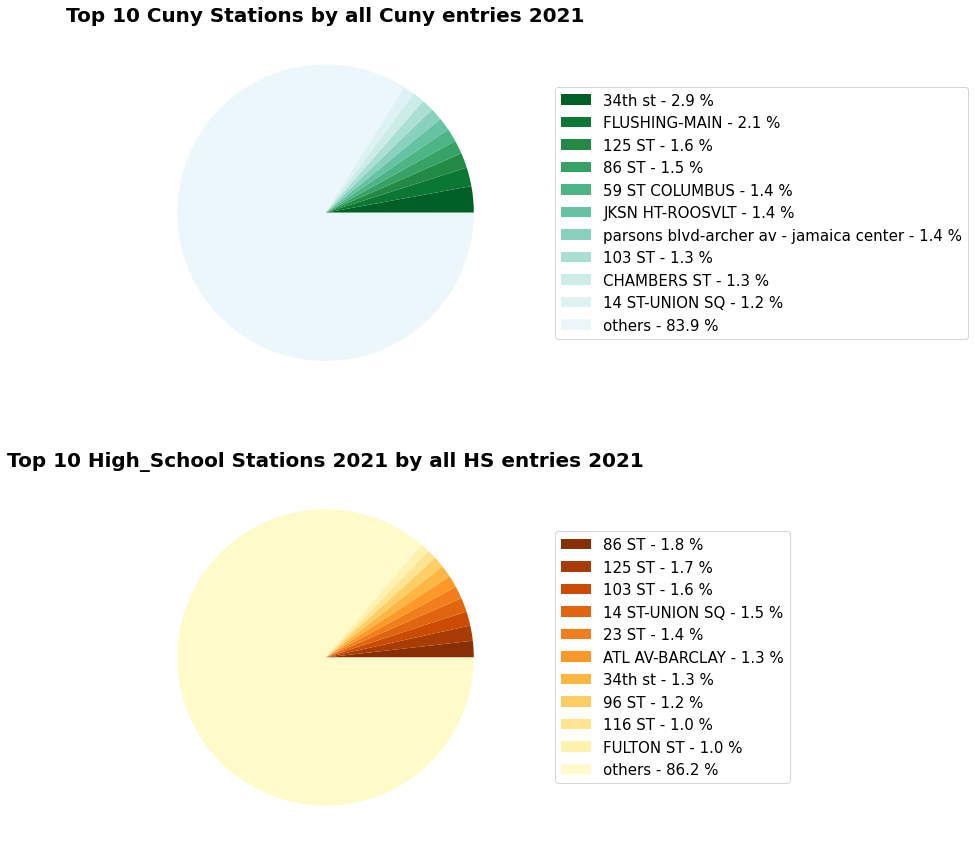

In [97]:
fig, axs = plt.subplots(2, 1, figsize=(30, 15))

x_cuny = df2_cuny_temp['station']
y_cuny = df2_cuny_temp['daily_entries_cuny_students']
percent_cuny = 100.*y_cuny/y_cuny.sum()

labels_cuny = ['{0} - {1:1.1f} %'.format(i, j) for i, j in zip(x_cuny, percent_cuny)]
sort_legend=True

colors_cuny = sns.color_palette('BuGn', 11).as_hex()[::-1]
colors_hs = sns.color_palette('YlOrBr', 11).as_hex()[::-1]

x_hs = df2_hs_temp['station']
y_hs = df2_hs_temp['daily_entries_high_school_students']
percent_hs = 100.*y_hs/y_hs.sum()

labels_hs = ['{0} - {1:1.1f} %'.format(i, j) for i, j in zip(x_hs, percent_hs)]

axs[0].set_title('Top 10 Cuny Stations by all Cuny entries 2021', fontsize=20,fontweight="bold")
axs[0].pie(y_cuny, colors=colors_cuny)
axs[0].legend(labels_cuny, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=15)

axs[1].set_title('Top 10 High_School Stations 2021 by all HS entries 2021', fontsize=20,fontweight="bold")
axs[1].pie(y_hs, colors=colors_hs)
axs[1].legend(labels_hs, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=15)
;

In [100]:
# Prepare data for visualizing pie chart with share of each group in total entries in 2021
entries_group_21 = entries_stations_21[['daily_entries_cuny_students', 'daily_entries_high_school_students', 
                                        'daily_entries_full_fares', 'daily_entries_unlimited',
                                       'daily_entries_railroad', 'daily_entries_mail_and_ride',
                                       'daily_entries_airtrain', 'daily_entries_seniors_disabled',
                                       'daily_entries_other']]

col_names = ['Cuny', 'High_school', 'Full_fare', 'Unlimited', 'Railroad', 'Mail_and_Ride',
 'Airtrain', 'Seniors_disabled', 'Other']

entries_group_21.columns = col_names
entries_group_21 = entries_group_21.melt().groupby('variable')[['value']].sum().reset_index()
entries_group_21.columns = ['Group', 'Value']
entries_group_21.sort_values('Value', inplace=True)

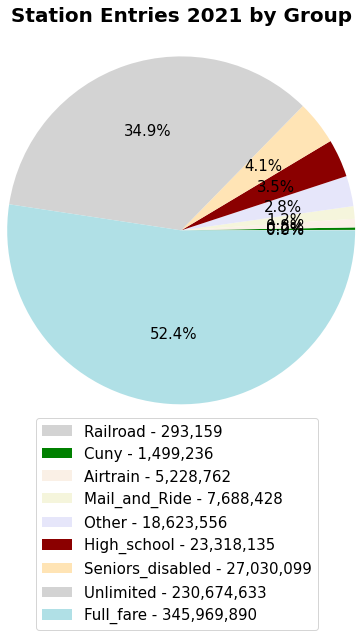

In [101]:
x = entries_group_21['Group']
y = entries_group_21['Value']

colors = ['lightgrey', 'green', 'linen', 'beige', 'lavender', 'darkred', 'moccasin', 'lightgrey', 'powderblue']

plt.pie(y, colors=colors, radius=2, autopct='%1.1f%%', textprops={'fontsize':15})

labels = ['{0} - {1:,.0f}'.format(i, j) for i, j in zip(x, y)]
sort_legend=True

plt.title('Station Entries 2021 by Group', fontsize=20,fontweight="bold", pad=100)
plt.legend(labels, loc='center left', bbox_to_anchor=(-0.2, -0.85), fontsize=15);

/tmp/ipykernel_47507/2621451043.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_xticklabels(top10_stations_cuny_21['station'], rotation='vertical', fontsize=20)
/tmp/ipykernel_47507/2621451043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(top10_stations_cuny_21['daily_entries_cuny_students'], fontsize=20)
/tmp/ipykernel_47507/2621451043.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_xticklabels(top10_stations_high_school_21['station'], rotation='vertical', fontsize=20)
/tmp/ipykernel_47507/2621451043.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_yticklabels(top10_stations_high_school_21['daily_entries_high_school_students'], fontsize=20)
/tmp/ipykernel_47507/2621451043.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set_xticklabels(xy

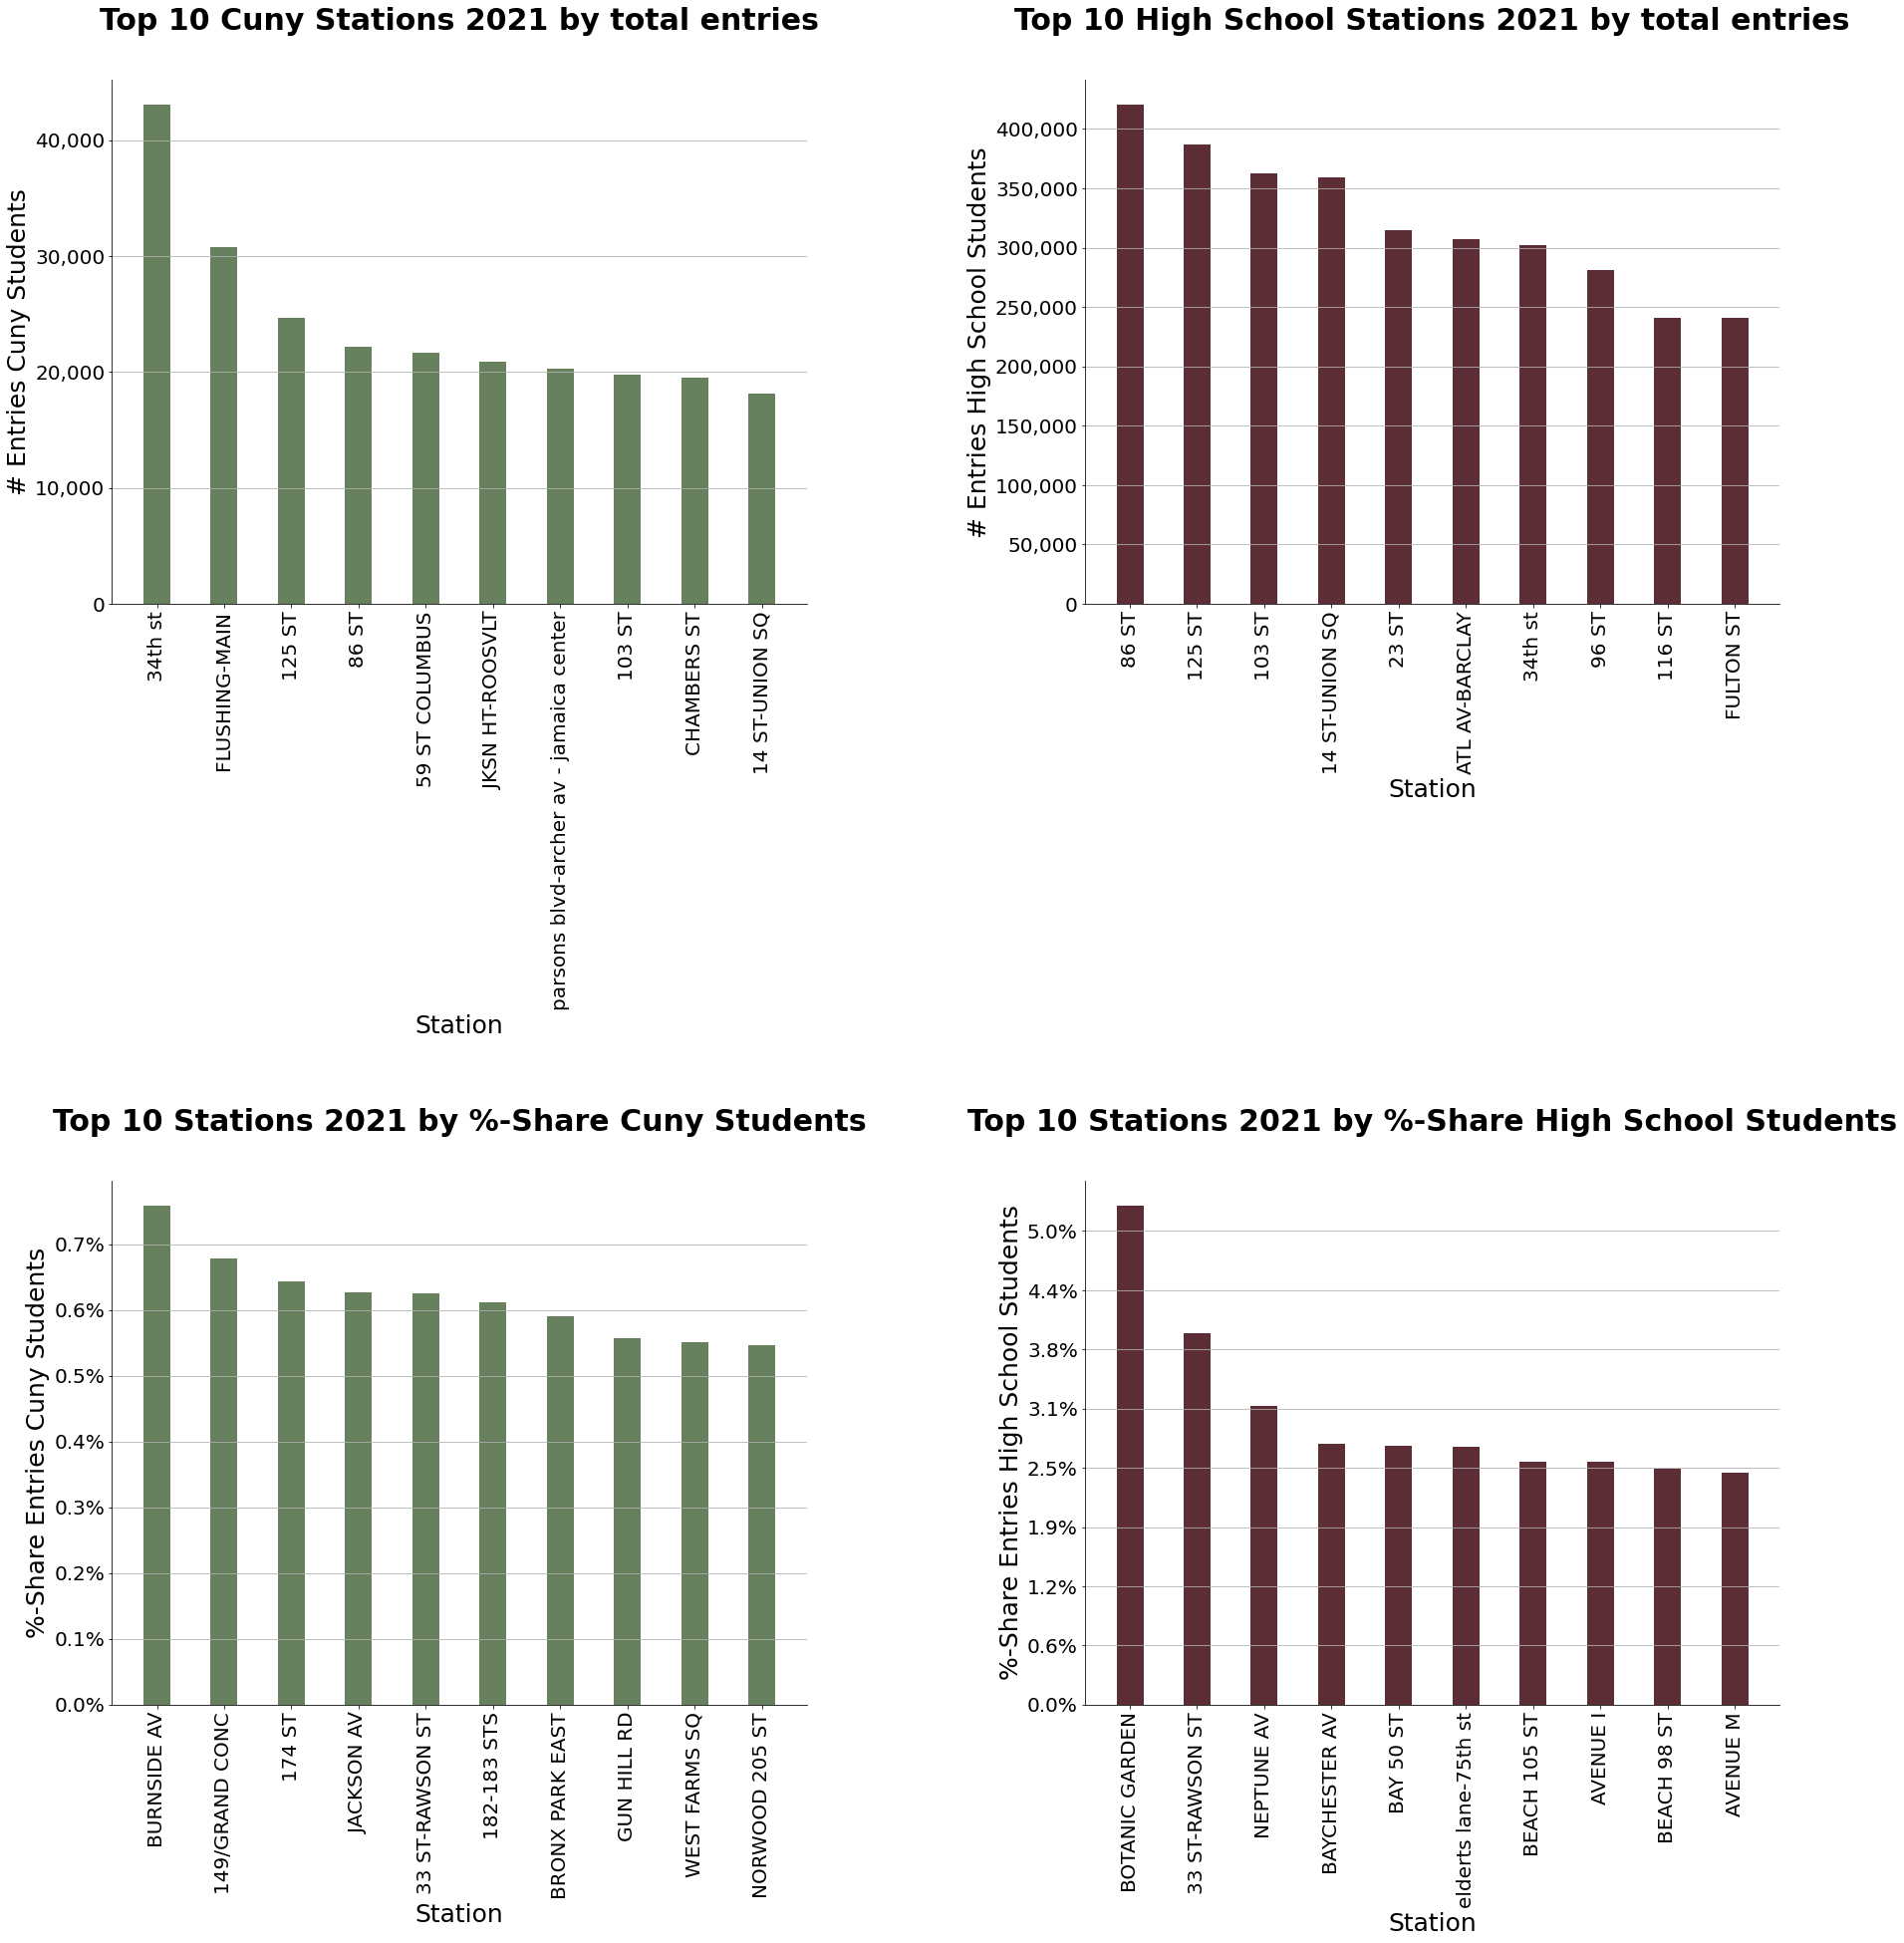

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(30, 30))
fig.subplots_adjust(wspace=0.4, hspace=1.1)

axs[0,0].bar(top10_stations_cuny_21['station'], top10_stations_cuny_21['daily_entries_cuny_students'], color='#67805e', width=0.4)
axs[0,0].set_xlabel('Station', fontsize=25)
axs[0,0].set_ylabel('# Entries Cuny Students', fontsize=25)
axs[0,0].set_xticklabels(top10_stations_cuny_21['station'], rotation='vertical', fontsize=20)
axs[0,0].set_yticklabels(top10_stations_cuny_21['daily_entries_cuny_students'], fontsize=20)
axs[0,0].set_title('Top 10 Cuny Stations 2021 by total entries', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[0,0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0,0].grid(axis='y')
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)

axs[0,1].bar(top10_stations_high_school_21['station'], top10_stations_high_school_21['daily_entries_high_school_students'], color='#5c2d35', width=0.4)
axs[0,1].set_xlabel('Station', fontsize=25)
axs[0,1].set_ylabel('# Entries High School Students', fontsize=25)
axs[0,1].set_xticklabels(top10_stations_high_school_21['station'], rotation='vertical', fontsize=20)
axs[0,1].set_yticklabels(top10_stations_high_school_21['daily_entries_high_school_students'], fontsize=20)
axs[0,1].set_title('Top 10 High School Stations 2021 by total entries', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[0,1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0,1].grid(axis='y')
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)

xy1 = entries_stations_21.sort_values(by='%_cuny', ascending=False).head(10)[['station', '%_cuny']].reset_index(drop=True)

axs[1,0].bar(xy1['station'], xy1['%_cuny'], color='#67805e', width=0.4)
axs[1,0].set_xlabel('Station', fontsize=25)
axs[1,0].set_ylabel('%-Share Entries Cuny Students', fontsize=25)
axs[1,0].set_xticklabels(xy1['station'], rotation='vertical', fontsize=20)
axs[1,0].set_yticklabels(xy1['%_cuny'], fontsize=20)
axs[1,0].set_title('Top 10 Stations 2021 by %-Share Cuny Students', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[1,0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1%}'.format(x)))
axs[1,0].grid(axis='y')
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)

xy2 = entries_stations_21.sort_values(by='%_high_school', ascending=False).head(10)[['station', '%_high_school']].reset_index(drop=True)

axs[1,1].bar(xy2['station'], xy2['%_high_school'], color='#5c2d35', width=0.4)
axs[1,1].set_xlabel('Station', fontsize=25)
axs[1,1].set_ylabel('%-Share Entries High School Students', fontsize=25)
axs[1,1].set_xticklabels(xy2['station'], rotation='vertical', fontsize=20)
axs[1,1].set_yticklabels(xy2['%_high_school'], fontsize=20)
axs[1,1].set_title('Top 10 Stations 2021 by %-Share High School Students', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[1,1].yaxis.set_major_formatter(ticker.PercentFormatter(4.0))
axs[1,1].grid(axis='y')
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)

plt.savefig("2022-03-14_Top10 Cuny Stations 2021.png", transparent=False, bbox_inches="tight");

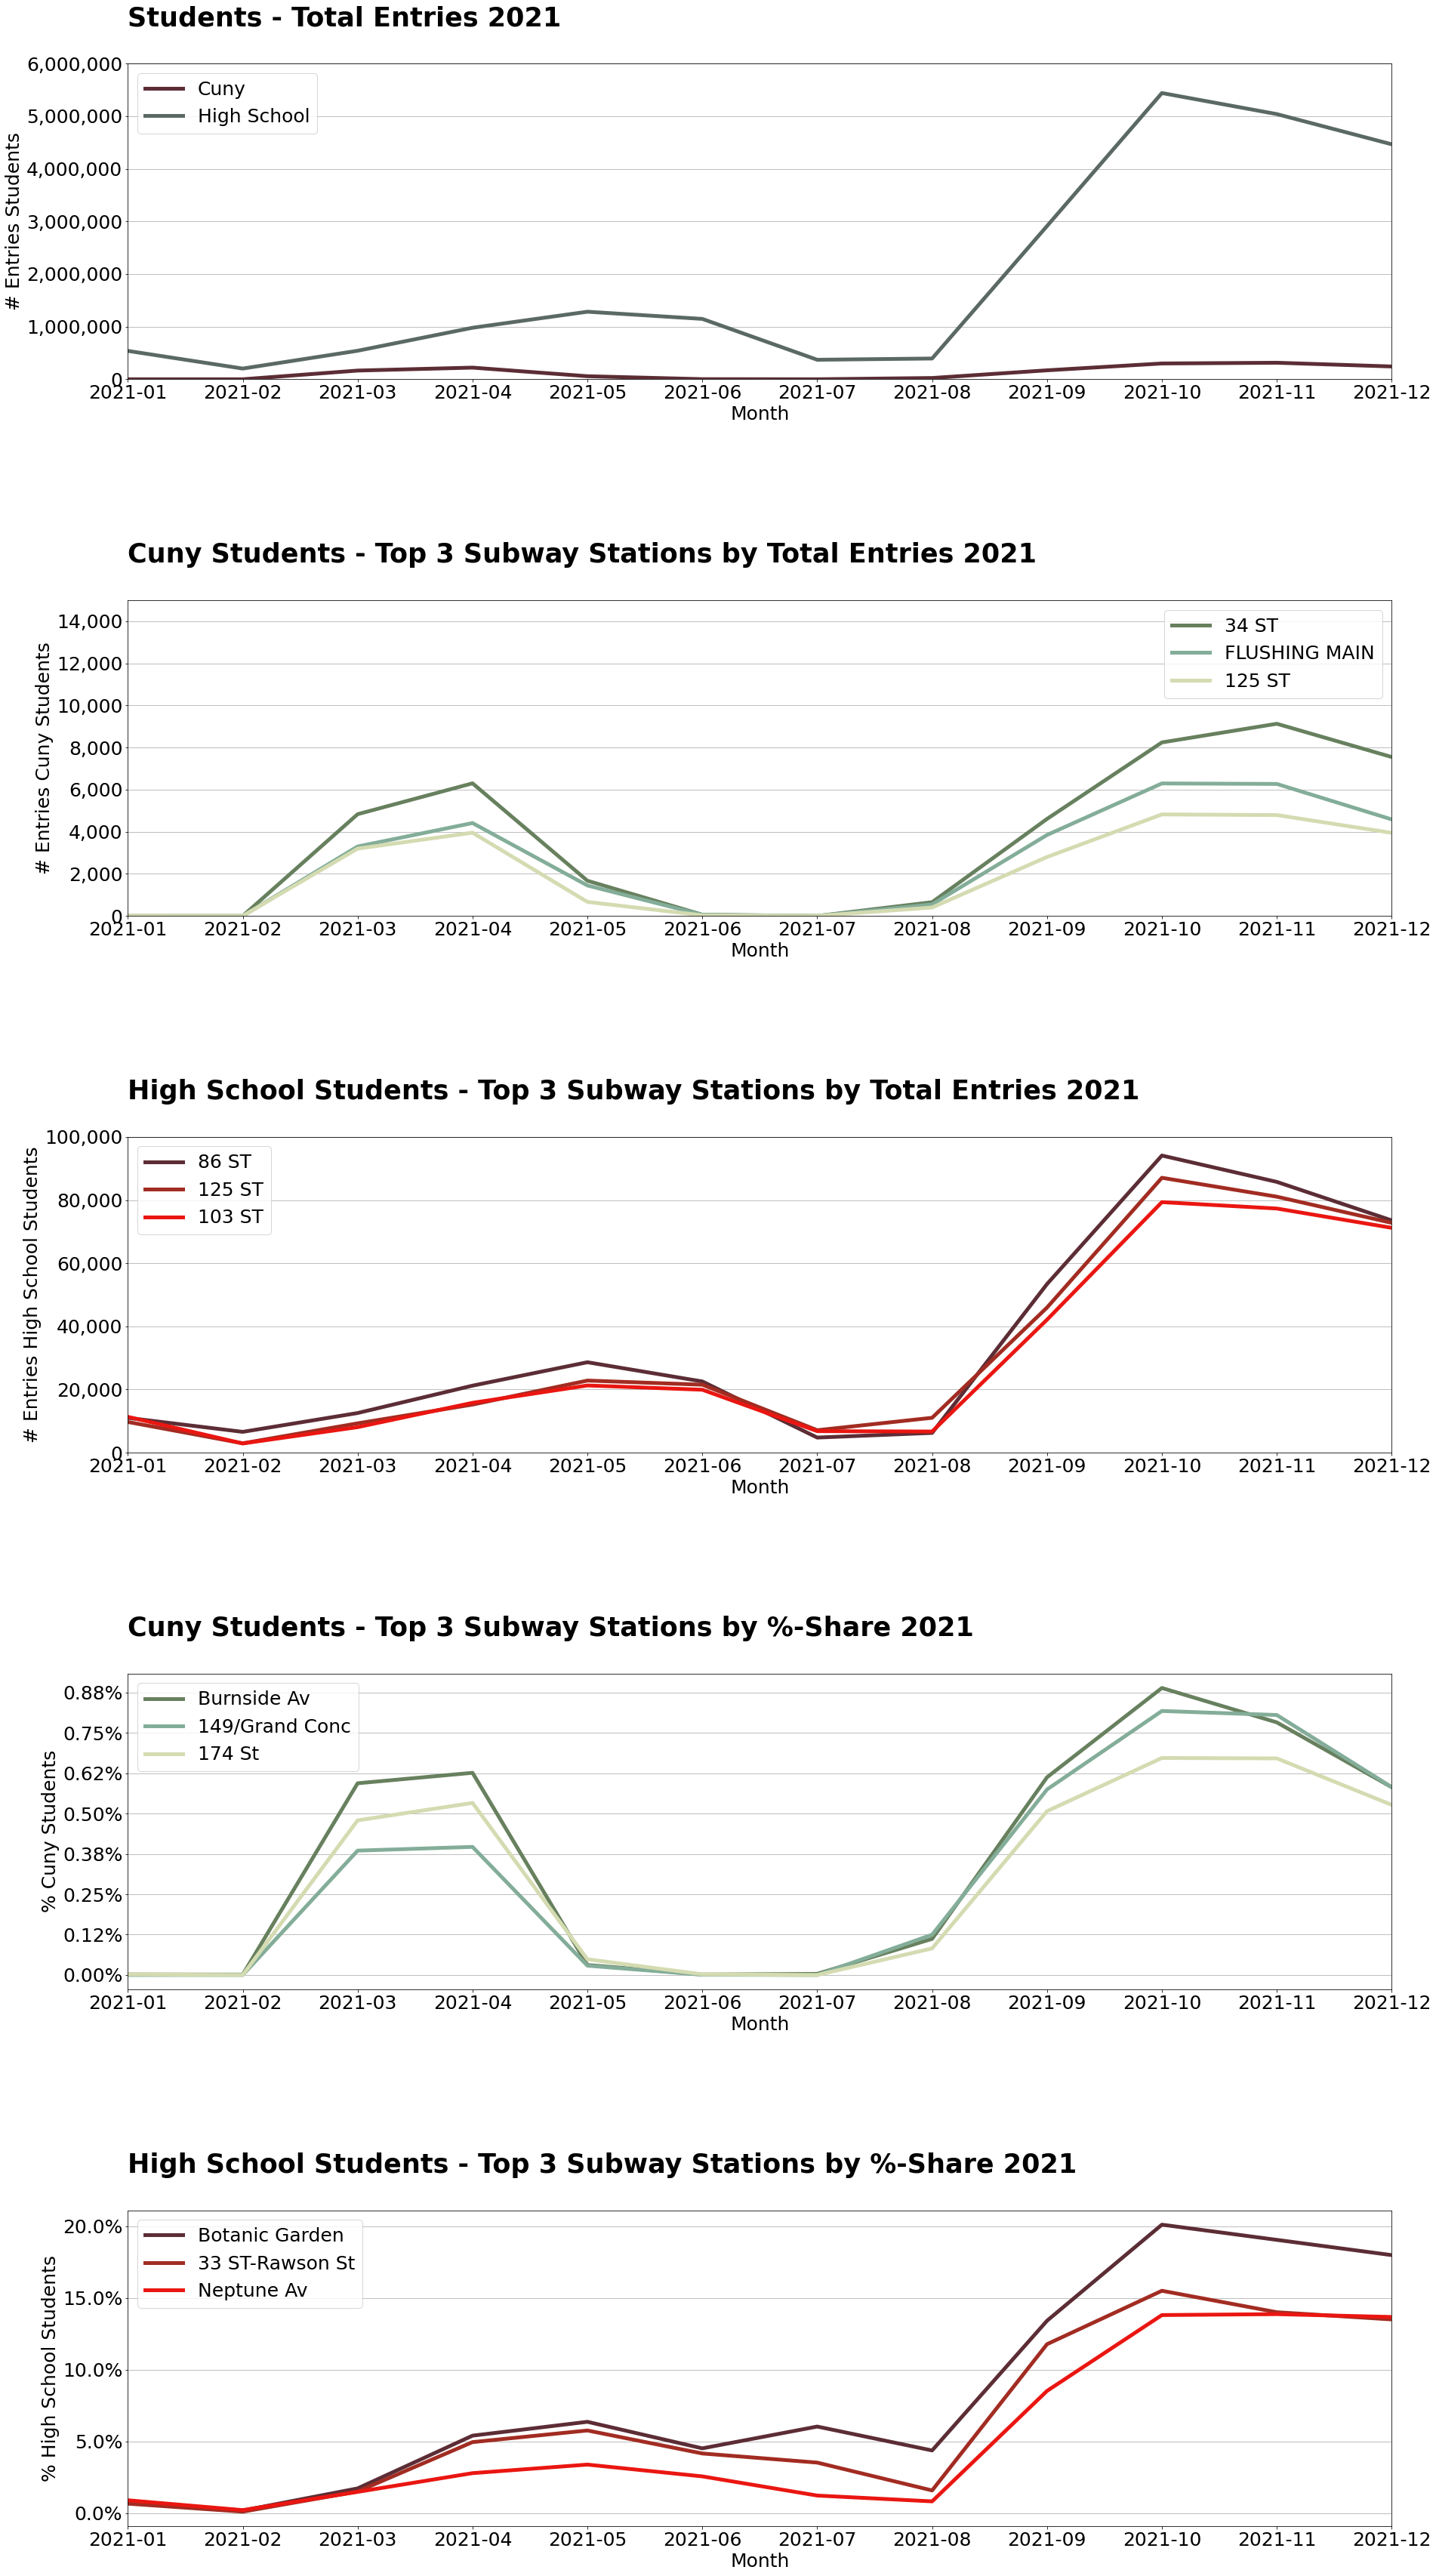

In [103]:
fig, axs = plt.subplots(5, 1, figsize=(30, 60))
fig.subplots_adjust(wspace=0.3, hspace=0.7)

axs[0].plot(data_cuny_total_21['month_year'], data_cuny_total_21['daily_entries_cuny_students'], linewidth=5, c='#5c2d35')
axs[0].plot(data_hs_total_21['month_year'], data_hs_total_21['daily_entries_high_school_students'], linewidth=5, c='#5b6965')
axs[0].legend(['Cuny', 'High School'], loc='best', fontsize=25)
axs[0].set_xlabel('Month', fontsize=25)
axs[0].set_ylabel('# Entries Students', fontsize=25)
axs[0].xaxis.set_tick_params(labelsize=25)
axs[0].yaxis.set_tick_params(labelsize=25)
axs[0].set_title('Students - Total Entries 2021', fontsize=35, fontweight='bold', loc='left', pad=50)
axs[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].grid(axis='y')
axs[0].set_xlim('2021-01', '2021-12')
axs[0].set_ylim(0, 6000000)

axs[1].plot(daily_cuny_34['month_year'], daily_cuny_34['daily_entries_cuny_students'], linewidth=5, c='#67805e')
axs[1].plot(daily_cuny_flushing['month_year'], daily_cuny_flushing['daily_entries_cuny_students'], linewidth=5, c='#83ad99')
axs[1].plot(daily_cuny_125['month_year'], daily_cuny_125['daily_entries_cuny_students'], linewidth=5, c='#d4dbb1')
axs[1].legend(['34 ST', 'FLUSHING MAIN', '125 ST'], loc='best', fontsize=25)
axs[1].set_xlabel('Month', fontsize=25)
axs[1].set_ylabel('# Entries Cuny Students', fontsize=25)
axs[1].xaxis.set_tick_params(labelsize=25)
axs[1].yaxis.set_tick_params(labelsize=25)
axs[1].set_title('Cuny Students - Top 3 Subway Stations by Total Entries 2021', fontsize=35, fontweight='bold', loc='left', pad=50)
axs[1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].grid(axis='y')
axs[1].set_xlim('2021-01', '2021-12')
axs[1].set_ylim(0, 15000)

axs[2].plot(daily_hs_86['month_year'], daily_hs_86['daily_entries_high_school_students'], linewidth=5, c='#5c2d35')
axs[2].plot(daily_hs_125['month_year'], daily_hs_125['daily_entries_high_school_students'], linewidth=5, c='#a22c22')
axs[2].plot(daily_hs_103['month_year'], daily_hs_103['daily_entries_high_school_students'], linewidth=5, c='#ea1611')
axs[2].legend(['86 ST', '125 ST', '103 ST'], loc='best', fontsize=25)
axs[2].set_xlabel('Month', fontsize=25)
axs[2].set_ylabel('# Entries High School Students', fontsize=25)
axs[2].xaxis.set_tick_params(labelsize=25)
axs[2].yaxis.set_tick_params(labelsize=25)
axs[2].set_title('High School Students - Top 3 Subway Stations by Total Entries 2021', fontsize=35, fontweight='bold', loc='left', pad=50)
axs[2].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[2].grid(axis='y')
axs[2].set_xlim('2021-01', '2021-12')
axs[2].set_ylim(0, 100000)

axs[3].plot(daily_cuny_pct_burnside['month_year'], daily_cuny_pct_burnside['%_cuny'], linewidth=5, c='#67805e')
axs[3].plot(daily_cuny_pct_149grandconc['month_year'], daily_cuny_pct_149grandconc['%_cuny'], linewidth=5, c='#83ad99')
axs[3].plot(daily_cuny_pct_174st['month_year'], daily_cuny_pct_174st['%_cuny'], linewidth=5, c='#d4dbb1')
axs[3].legend(['Burnside Av', '149/Grand Conc', '174 St'], loc='best', fontsize=25)
axs[3].set_xlabel('Month', fontsize=25)
axs[3].set_ylabel('% Cuny Students', fontsize=25)
axs[3].xaxis.set_tick_params(labelsize=25)
axs[3].yaxis.set_tick_params(labelsize=25)
axs[3].set_title('Cuny Students - Top 3 Subway Stations by %-Share 2021', fontsize=35, fontweight='bold', loc='left', pad=50)
axs[3].yaxis.set_major_formatter(ticker.PercentFormatter(2.0))
axs[3].grid(axis='y')
axs[3].set_xlim('2021-01', '2021-12')

axs[4].plot(daily_hs_pct_botanic['month_year'], daily_hs_pct_botanic['%_high_school'], linewidth=5, c='#5c2d35')
axs[4].plot(daily_hs_pct_33st['month_year'], daily_hs_pct_33st['%_high_school'], linewidth=5, c='#a22c22')
axs[4].plot(daily_hs_pct_neptun['month_year'], daily_hs_pct_neptun['%_high_school'], linewidth=5, c='#ea1611')
axs[4].legend(['Botanic Garden', '33 ST-Rawson St', 'Neptune Av'], loc='best', fontsize=25)
axs[4].set_xlabel('Month', fontsize=25)
axs[4].set_ylabel('% High School Students', fontsize=25)
axs[4].xaxis.set_tick_params(labelsize=25)
axs[4].yaxis.set_tick_params(labelsize=25)
axs[4].set_title('High School Students - Top 3 Subway Stations by %-Share 2021', fontsize=35, fontweight='bold', loc='left', pad=50)
axs[4].yaxis.set_major_formatter(ticker.PercentFormatter(2.0))
axs[4].grid(axis='y')
axs[4].set_xlim('2021-01', '2021-12');

**Stations with most College or High-School students**

**MVP overview**

> - **Goal**: This analysis seeks to identify the subway stations with the highest number of entries of current and prospective students and its evlution at these stations over time. As an approximation, data metrocard swipes of CUNY and High-School students at different stations was mapped on turnstile data on entries at different subway stations.

> - **Process**: Data exploration to reach a conclusion entailed aggregation of entry data to the station level for the mta turnstile data. Percentage shares of CUNY and High-School metrocard swipes by station were calculated by calendar week from mta fare data and merged on mta turnstile data.

> - **Preliminary visualization**: The first 4 visualizations below show the top 10 subway stations with (a) highest total entries by Cuny and High-School students in 2021 and (b) highest %-share of Cuny and High-School students in total entries in 2021. The further 5 visualizations explorate on this and show the development of total Cuny / High School entries and %-share of top 3 subway stations by month in 2021.

> - **Preliminary conclusions**: From a marketing perspective we may reach most CUNY with display ads at Flushing Main, 125 St, 86 St and most High-School students at 86 St, 125 St and 14-St Union Sq. Targeting a more homogenuous group we should focus on Burnside Av, 149/Grand Conc and 174 St for CUNY students and on Botanic Garden, 33 ST-Rawson St and Neptune Av for High-School students.

In [104]:
monthly_entries_station_loc['station_longitude'] = monthly_entries_station_loc['station_longitude'].astype('float')
monthly_entries_station_loc['station_latitude'] = monthly_entries_station_loc['station_latitude'].astype('float')
monthly_entries_station_loc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4894 entries, 0 to 4893
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   station                             4894 non-null   object 
 1   month_year                          4894 non-null   object 
 2   station_match                       4894 non-null   object 
 3   daily_entries                       4894 non-null   float64
 4   daily_entries_cuny_students         4894 non-null   float64
 5   daily_entries_high_school_students  4894 non-null   float64
 6   daily_entries_full_fares            4894 non-null   float64
 7   daily_entries_unlimited             4894 non-null   float64
 8   daily_entries_railroad              4894 non-null   float64
 9   daily_entries_mail_and_ride         4894 non-null   float64
 10  daily_entries_airtrain              4894 non-null   float64
 11  daily_entries_seniors_disabled      4894 no

In [105]:
d5_check = sum(monthly_entries_station_loc['daily_entries'])
print((d5_check == d1_check), d5_check)

True 666797844.0


# Prepare Geo Map with Bookeh

https://towardsdatascience.com/creating-an-interactive-map-in-python-using-bokeh-and-pandas-f84414536a06

In [106]:
# Prepare entries (sum) and coordinates (mean) for plotting geographical map
top_stations_cuny = monthly_entries_station_loc.groupby(['station'])[['daily_entries_cuny_students', 'station_latitude', 'station_longitude']].agg(
    {'daily_entries_cuny_students': 'sum', 'station_latitude': 'mean', 'station_longitude': 'mean'}).sort_values(by='daily_entries_cuny_students', ascending=False).reset_index().head(30)
# top_stations_cuny.head(30)

In [107]:
# Convert long-lat coordinates to mercator system
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lat * (np.pi/180.0)/2.0)) * scale
    return(x, y)

top_stations_cuny['coordinates'] = list(zip(top_stations_cuny['station_latitude'], 
                                             top_stations_cuny['station_longitude']))

mercators = [x_coord(x, y) for x, y in top_stations_cuny['coordinates']]

In [108]:
top_stations_cuny['mercator'] = mercators

top_stations_cuny[['mercator_x', 'mercator_y']] = top_stations_cuny['mercator'].apply(pd.Series)

In [109]:
# top_stations_cuny.head()

In [110]:
chosentile = get_provider(Vendors.STAMEN_TONER)
palette = BuGn[9]
source = ColumnDataSource(data=top_stations_cuny)

color_mapper = linear_cmap(field_name='daily_entries_cuny_students', palette=palette, low = top_stations_cuny['daily_entries_cuny_students'].max(),
                          high=top_stations_cuny['daily_entries_cuny_students'].min())

tooltips = [('Entries CUNY', '@daily_entries_cuny_students{,}'), ('Station', '@station')]

p = figure(title='Cuny Frequency at Top 30 New York Subway Stations 2021', x_axis_type='mercator', y_axis_type='mercator',
          x_axis_label='Longitude', y_axis_label='Latitude', tooltips=tooltips)

In [111]:
p.add_tile(chosentile)

TileRenderer(id='1048', ...)

In [112]:
p.circle(x='mercator_x', y='mercator_y', color=color_mapper, source=source, size=30, fill_alpha=0.7)

GlyphRenderer(id='1056', ...)

In [113]:
color_bar = ColorBar(color_mapper=color_mapper['transform'], formatter=NumeralTickFormatter(format='0.0[0000]'),
                    label_standoff=13, width=8, location=(0,0))

p.add_layout(color_bar, 'right')

output_notebook()

Loading BokehJS ...

In [114]:
output_file('station_cuny_students_2021.html', title='Cuny Frequency at New York Subway Stations 2021')

show(p)

In [115]:
top_stations_hs = monthly_entries_station_loc.groupby(['station'])[['daily_entries_high_school_students', 'station_latitude', 'station_longitude']].agg(
    {'daily_entries_high_school_students': 'sum', 'station_latitude': 'mean', 'station_longitude': 'mean'}).sort_values(by='daily_entries_high_school_students', ascending=False).reset_index().head(30)
# top_stations_cuny.head(30)

In [116]:
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lat * (np.pi/180.0)/2.0)) * scale
    return(x, y)

top_stations_hs['coordinates'] = list(zip(top_stations_hs['station_latitude'], 
                                             top_stations_hs['station_longitude']))

mercators = [x_coord(x, y) for x, y in top_stations_hs['coordinates']]

In [117]:
top_stations_hs['mercator'] = mercators

top_stations_hs[['mercator_x', 'mercator_y']] = top_stations_hs['mercator'].apply(pd.Series)

In [118]:
# top_stations_hs.head()

In [119]:
chosentile = get_provider(Vendors.STAMEN_TONER)
palette = YlOrBr[9]
source = ColumnDataSource(data=top_stations_hs)

color_mapper = linear_cmap(field_name='daily_entries_high_school_students', palette=palette, low = top_stations_hs['daily_entries_high_school_students'].max(),
                          high=top_stations_hs['daily_entries_high_school_students'].min())

tooltips = [('Entries High School', '@daily_entries_high_school_students{,}'), ('Station', '@station')]

p = figure(title='High School Frequency at Top 30 New York Subway Stations 2021', x_axis_type='mercator', y_axis_type='mercator',
          x_axis_label='Longitude', y_axis_label='Latitude', tooltips=tooltips)

In [120]:
p.add_tile(chosentile)

TileRenderer(id='1308', ...)

In [121]:
p.circle(x='mercator_x', y='mercator_y', color=color_mapper, source=source, size=30, fill_alpha=0.7)

GlyphRenderer(id='1316', ...)

In [122]:
color_bar = ColorBar(color_mapper=color_mapper['transform'], formatter=NumeralTickFormatter(format='0.0[0000]'),
                    label_standoff=13, width=8, location=(0,0))

p.add_layout(color_bar, 'right')

output_notebook()

Loading BokehJS ...

In [123]:
output_file('station_high_school_students_2021.html', title='High School Frequency at New York Subway Stations 2021')

show(p)

# Calculate lines with highest cuny and high-school frequencies

In [125]:
# Calculate percentages for linear allocation of entries for each station to each line
station_data['pct_temp'] = 1 / station_data['count_lines']
station_data

,station_name,line,count_lines,pct_temp
1287,86th st,Broadway-7th Ave,5,0.2
25,86th st,4 Avenue,5,0.2
467,23rd st,6 Avenue,5,0.2
116,23rd st,Broadway,5,0.2
1587,23rd st,Lexington,5,0.2
...,...,...,...,...
1161,broad channel,Rockaway,1,1.0
84,brighton beach,Brighton,1,1.0
1046,briarwood-van wyck blvd,Queens Boulevard,1,1.0
1663,bowling green,Lexington,1,1.0


In [126]:
# Prepare entry data (group by station) for subsequent merge with line-data
line_temp = data_monthly_entries_station.loc[(data_monthly_entries_station[
    'month_year'] >= '2021-01') & (data_monthly_entries_station[
    'month_year'] <= '2021-12'), :].groupby(
    ['station_match'])[['daily_entries','daily_entries_cuny_students',
                  'daily_entries_high_school_students']].sum().sort_values(by='daily_entries_cuny_students', ascending=False).reset_index()

In [127]:
line_data = station_data.merge(line_temp, how='inner', left_on='station_name', right_on='station_match')

In [128]:
line_data.head(5)

,station_name,line,count_lines,pct_temp,station_match,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students
0,86th st,Broadway-7th Ave,5,0.2,86th st,10567536.0,22199.494041,420424.547426
1,86th st,4 Avenue,5,0.2,86th st,10567536.0,22199.494041,420424.547426
2,86th st,8 Avenue,5,0.2,86th st,10567536.0,22199.494041,420424.547426
3,86th st,Lexington,5,0.2,86th st,10567536.0,22199.494041,420424.547426
4,86th st,Sea Beach,5,0.2,86th st,10567536.0,22199.494041,420424.547426


In [129]:
line_data['line_cuny'] = line_data['daily_entries_cuny_students'] * line_data['pct_temp']
line_data['line_high_school'] = line_data['daily_entries_high_school_students'] * line_data['pct_temp']
line_data['entries_all'] = line_data['daily_entries'] * line_data['pct_temp']
line_data.head(10)

,station_name,line,count_lines,pct_temp,station_match,daily_entries,daily_entries_cuny_students,daily_entries_high_school_students,line_cuny,line_high_school,entries_all
0,86th st,Broadway-7th Ave,5,0.2,86th st,10567536.0,22199.494041,420424.547426,4439.898808,84084.909485,2113507.2
1,86th st,4 Avenue,5,0.2,86th st,10567536.0,22199.494041,420424.547426,4439.898808,84084.909485,2113507.2
2,86th st,8 Avenue,5,0.2,86th st,10567536.0,22199.494041,420424.547426,4439.898808,84084.909485,2113507.2
3,86th st,Lexington,5,0.2,86th st,10567536.0,22199.494041,420424.547426,4439.898808,84084.909485,2113507.2
4,86th st,Sea Beach,5,0.2,86th st,10567536.0,22199.494041,420424.547426,4439.898808,84084.909485,2113507.2
5,23rd st,6 Avenue,5,0.2,23rd st,10081326.0,14760.998207,314849.911767,2952.199641,62969.982353,2016265.2
6,23rd st,Broadway,5,0.2,23rd st,10081326.0,14760.998207,314849.911767,2952.199641,62969.982353,2016265.2
7,23rd st,Lexington,5,0.2,23rd st,10081326.0,14760.998207,314849.911767,2952.199641,62969.982353,2016265.2
8,23rd st,8 Avenue,5,0.2,23rd st,10081326.0,14760.998207,314849.911767,2952.199641,62969.982353,2016265.2
9,23rd st,Broadway-7th Ave,5,0.2,23rd st,10081326.0,14760.998207,314849.911767,2952.199641,62969.982353,2016265.2


In [130]:
# Prepare data for visualization of Top 10 lines by entries (total and %-share)
line_data_g = line_data.groupby('line')[['line_cuny', 'line_high_school', 'entries_all']].sum().sort_values('line_cuny', ascending=False).reset_index()
line_data_g['%_cuny'] = line_data_g['line_cuny'] / line_data_g['entries_all'] 
line_data_g['%_high_school'] = line_data_g['line_high_school'] / line_data_g['entries_all']

line_top10_cuny_val = line_data_g[['line', 'line_cuny']].sort_values('line_cuny', ascending=False).head(10)
line_top10_cuny_pct = line_data_g[['line', '%_cuny']].sort_values('%_cuny', ascending=False).head(10)

line_top10_hs_val = line_data_g[['line', 'line_high_school']].sort_values('line_high_school', ascending=False).head(10)
line_top10_hs_pct = line_data_g[['line', '%_high_school']].sort_values('%_high_school', ascending=False).head(10)

line_top10_cuny_val

,line,line_cuny
0,Broadway-7th Ave,134227.548190
1,Flushing,111312.316143
2,Queens Boulevard,107874.718353
3,Lexington,100407.791847
4,8 Avenue,98231.203265
5,Jerome,83708.125845
6,Broadway,78860.514379
7,6 Avenue,64549.605981
8,White Plains Road,63909.254517
9,Concourse,61671.120977


/tmp/ipykernel_47507/675438996.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_xticklabels(line_top10_cuny_val['line'], rotation='vertical', fontsize=20)
/tmp/ipykernel_47507/675438996.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(line_top10_cuny_val['line_cuny'], fontsize=20)
/tmp/ipykernel_47507/675438996.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_xticklabels(line_top10_hs_val['line'], rotation='vertical', fontsize=20)
/tmp/ipykernel_47507/675438996.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_yticklabels(line_top10_hs_val['line_high_school'], fontsize=20)
/tmp/ipykernel_47507/675438996.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set_xticklabels(xy1['line'], rotation='vertical', fontsize=20)
/tmp/ipykernel_47507/675438996.p

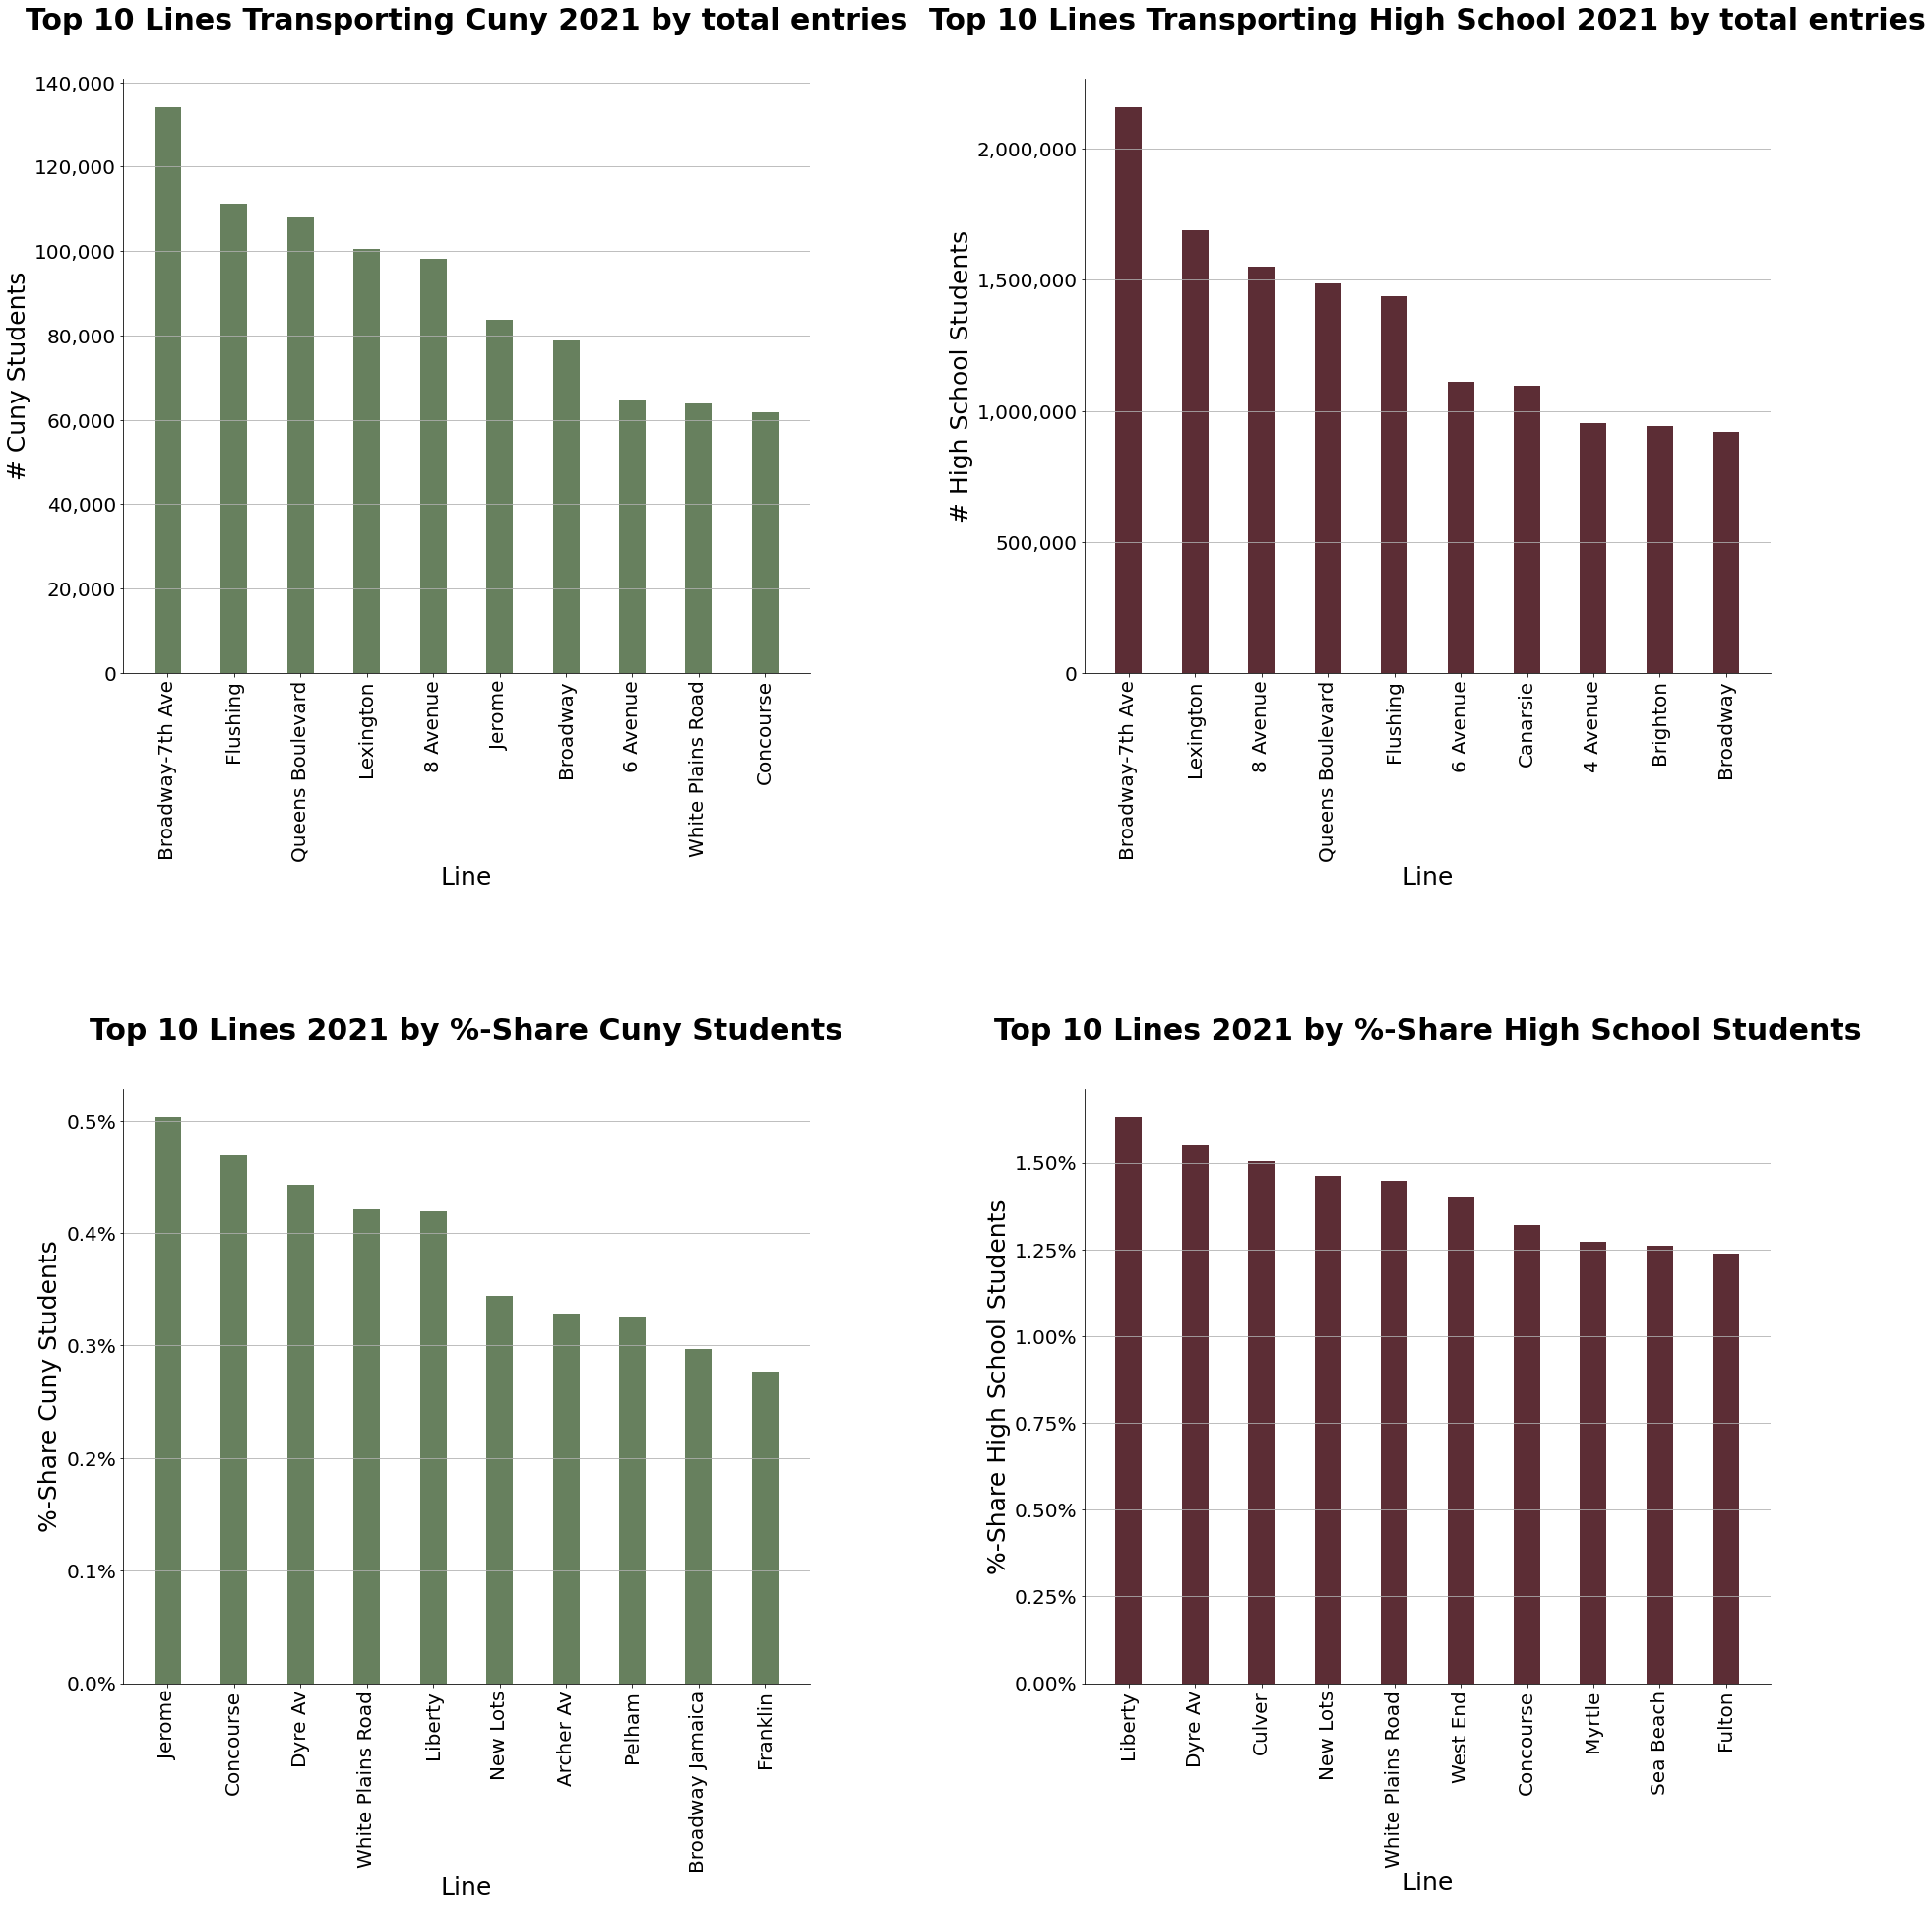

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(30, 30))
fig.subplots_adjust(wspace=0.4, hspace=0.7)

axs[0,0].bar(line_top10_cuny_val['line'], line_top10_cuny_val['line_cuny'], color='#67805e', width=0.4)
axs[0,0].set_xlabel('Line', fontsize=25)
axs[0,0].set_ylabel('# Cuny Students', fontsize=25)
axs[0,0].set_xticklabels(line_top10_cuny_val['line'], rotation='vertical', fontsize=20)
axs[0,0].set_yticklabels(line_top10_cuny_val['line_cuny'], fontsize=20)
axs[0,0].set_title('Top 10 Lines Transporting Cuny 2021 by total entries', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[0,0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0,0].grid(axis='y')
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)

axs[0,1].bar(line_top10_hs_val['line'], line_top10_hs_val['line_high_school'], color='#5c2d35', width=0.4)
axs[0,1].set_xlabel('Line', fontsize=25)
axs[0,1].set_ylabel('# High School Students', fontsize=25)
axs[0,1].set_xticklabels(line_top10_hs_val['line'], rotation='vertical', fontsize=20)
axs[0,1].set_yticklabels(line_top10_hs_val['line_high_school'], fontsize=20)
axs[0,1].set_title('Top 10 Lines Transporting High School 2021 by total entries', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[0,1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0,1].grid(axis='y')
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)

xy1 = line_top10_cuny_pct.sort_values(by='%_cuny', ascending=False).head(10)[['line', '%_cuny']].reset_index(drop=True)

axs[1,0].bar(xy1['line'], xy1['%_cuny'], color='#67805e', width=0.4)
axs[1,0].set_xlabel('Line', fontsize=25)
axs[1,0].set_ylabel('%-Share Cuny Students', fontsize=25)
axs[1,0].set_xticklabels(xy1['line'], rotation='vertical', fontsize=20)
axs[1,0].set_yticklabels(xy1['%_cuny'], fontsize=20)
axs[1,0].set_title('Top 10 Lines 2021 by %-Share Cuny Students', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[1,0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1%}'.format(x)))
axs[1,0].grid(axis='y')
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)

xy2 = line_top10_hs_pct.sort_values(by='%_high_school', ascending=False).head(10)[['line', '%_high_school']].reset_index(drop=True)

axs[1,1].bar(xy2['line'], xy2['%_high_school'], color='#5c2d35', width=0.4)
axs[1,1].set_xlabel('Line', fontsize=25)
axs[1,1].set_ylabel('%-Share High School Students', fontsize=25)
axs[1,1].set_xticklabels(xy2['line'], rotation='vertical', fontsize=20)
axs[1,1].set_yticklabels(xy2['%_high_school'], fontsize=20)
axs[1,1].set_title('Top 10 Lines 2021 by %-Share High School Students', fontsize=30, fontweight='bold', loc='center', pad=50)
axs[1,1].yaxis.set_major_formatter(ticker.PercentFormatter(4.0))
axs[1,1].grid(axis='y')
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False);

''

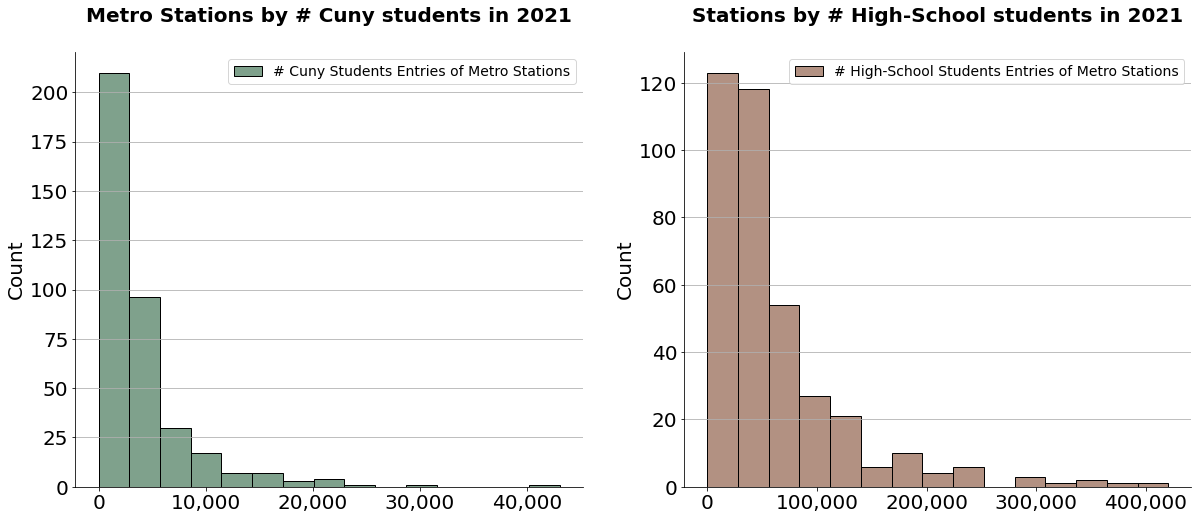

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.7)

sns.histplot(entries_stations_21[['station', 'daily_entries_cuny_students']], bins=15, ax=axs[0], palette=BuGn[9])
sns.histplot(entries_stations_21[['station', 'daily_entries_high_school_students']], bins=15, ax=axs[1], palette=YlOrBr[9])

axs[0].legend(labels=['# Cuny Students Entries of Metro Stations'], fontsize=14)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylabel("Count",fontsize=20)
axs[0].tick_params(labelsize=20)
axs[0].set_title('Metro Stations by # Cuny students in 2021', fontsize=20, fontweight='bold', loc='center', pad=30)

axs[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
axs[0].grid(axis='y')

axs[1].legend(labels=['# High-School Students Entries of Metro Stations'], fontsize=14)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_ylabel("Count",fontsize=20)
axs[1].tick_params(labelsize=20)
axs[1].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
axs[1].grid(axis='y')
axs[1].set_title('Stations by # High-School students in 2021', fontsize=20, fontweight='bold', loc='center', pad=30)
;